In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import big_model, aflare, calculate_specific_flare_flux, aflare
from funcs.flarefit import log_probability

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

#from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

In [2]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [3]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

,prefix,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot
0,TIC,237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43
1,KIC,100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88
2,TIC,44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71
3,TIC,277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56
4,EPIC,212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,29.07702,2.06769,4.63


In [4]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [5]:
lcs.columns.values

array(['ID', 'QCS', 'typ', 'cadence_min', 'mission', 'prefix', 'origin',
       'h_mission', 'SpT', 'view_start', 'view_stop', 'view_min',
       'view_max', 'BJDoff', 'tstart', 'ampl_min', 'ampl_max', 'RA',
       'Dec', 'J', 'R', 'Gaia_G', 'vsini_kms', 'e_vsini_kms', 'Prot_d',
       'sini', 'Ref', 'identifier', 'Rstar', 'ED', 'e_ED', 't0', 'e_t0',
       'dur', 'e_dur', 'ampl', 'e_ampl', 'Prot', 'idtyp', 'id', 'st',
       'desig_2mass', 'dist', 'dist_err', 'dist_source', 'rad', 'tflux',
       'tlum', 'kflux', 'klum', 'gmag', 'jmag', 'kmag'], dtype=object)

In [6]:
lcs = get_incl(lcs)
target = lcs.iloc[2]
target

ID                           237880881
QCS                                  1
typ                                slc
cadence_min                          2
mission                           tess
prefix                             TIC
origin                         generic
h_mission                         TESS
SpT                                 M5
view_start                        1331
view_stop                       1333.5
view_min                           560
view_max                           700
BJDoff                         2457000
tstart                          1331.7
ampl_min                           NaN
ampl_max                           NaN
RA                              19.528
Dec                           -62.9831
J                                11.53
R                                  NaN
Gaia_G                         14.9796
vsini_kms                         14.4
e_vsini_kms                        2.6
Prot_d                         0.35125
sini                     

In [7]:
flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)

choice = (t > target.view_start + .76) & (t < target.view_stop-.5)
t = t[choice]
flux = sflux[choice]
flux_err = np.mean(flck.flux_err)

In [7]:
#pd.DataFrame({"phi":phi,"flux":flux, "t":t,"flux_err":flux_err}).to_csv(f"{target.ID}.csv",index=False)
lc = pd.read_csv(f"{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values

In [42]:
target.Prot_d

0.35125

(1.0471975511965976, 0.3718561470554695, 1.33384941601076)

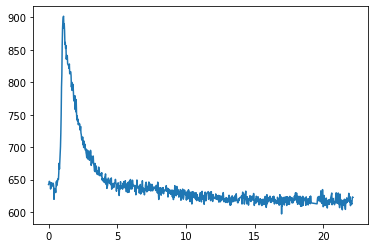

In [22]:
phi = (t - t[0])/target.Prot_d * 2 * np.pi
phi_a = (target.t0 - t[0])/target.Prot_d * 2 * np.pi +.2
theta_a = 60*np.pi/180
a = target.ampl+.1
fwhm = target.dur /target.Prot_d * 2 * np.pi/5
i_mu = target.incl
i_sigma = target.incl_err
#theta_a = i_mu +.1
#phi = np.linspace(0, 30*np.pi, N)
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
median = 615#np.nanmedian(flck.flux)
phi0 = 15 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
# m = big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
#               phi=phi, num_pts=50, qlum=qlum,
#               Fth=Fth, R=R, median=median)
# flare = aflare(phi, phi_a, fwhm, a*median,)
phi_a_max = phi[-1]
plt.plot(phi,flux)
theta_a, i_mu, phi_a

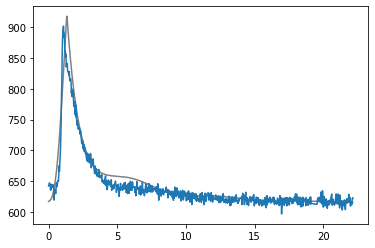

In [23]:
plt.plot(phi, big_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="grey", alpha=1,)
plt.plot(phi,flux)

## Run MCMC

In [29]:

inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":i_mu-i_sigma, "phi_a_max":phi_a_max}))
sampler.run_mcmc(pos, 2000, progress=True);

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 1/2000 [00:00<20:12,  1.65it/s]

  0%|          | 2/2000 [00:01<21:09,  1.57it/s]

  0%|          | 3/2000 [00:01<20:50,  1.60it/s]

  0%|          | 4/2000 [00:02<20:38,  1.61it/s]

  0%|          | 5/2000 [00:03<20:29,  1.62it/s]

  0%|          | 6/2000 [00:03<20:24,  1.63it/s]

  0%|          | 7/2000 [00:04<20:23,  1.63it/s]

  0%|          | 8/2000 [00:04<20:18,  1.63it/s]

  0%|          | 9/2000 [00:05<20:14,  1.64it/s]

  0%|          | 10/2000 [00:06<20:14,  1.64it/s]

  1%|          | 11/2000 [00:06<20:12,  1.64it/s]

prior inf


  1%|          | 12/2000 [00:07<20:01,  1.65it/s]

  1%|          | 13/2000 [00:07<20:04,  1.65it/s]

  1%|          | 14/2000 [00:08<20:04,  1.65it/s]

  1%|          | 15/2000 [00:09<19:54,  1.66it/s]

prior inf


  1%|          | 16/2000 [00:09<19:49,  1.67it/s]

prior inf


  1%|          | 17/2000 [00:10<19:44,  1.67it/s]

prior inf


  1%|          | 18/2000 [00:10<19:50,  1.66it/s]

  1%|          | 19/2000 [00:11<19:44,  1.67it/s]

prior inf


prior inf


  1%|          | 20/2000 [00:12<19:29,  1.69it/s]

prior inf


  1%|          | 21/2000 [00:12<19:18,  1.71it/s]

prior inf
prior inf


prior inf


  1%|          | 22/2000 [00:13<19:12,  1.72it/s]

prior inf


prior inf


  1%|          | 23/2000 [00:13<19:05,  1.73it/s]

prior inf


  1%|          | 24/2000 [00:14<19:11,  1.72it/s]

prior inf


prior inf


  1%|▏         | 25/2000 [00:15<19:15,  1.71it/s]

prior inf
prior inf


  1%|▏         | 26/2000 [00:15<19:07,  1.72it/s]

prior inf


  1%|▏         | 27/2000 [00:16<19:11,  1.71it/s]

  1%|▏         | 28/2000 [00:16<18:51,  1.74it/s]

prior inf
prior inf
prior inf


  1%|▏         | 29/2000 [00:17<19:11,  1.71it/s]

prior inf


  2%|▏         | 30/2000 [00:17<19:15,  1.70it/s]

prior inf


  2%|▏         | 31/2000 [00:18<19:06,  1.72it/s]

prior inf


  2%|▏         | 32/2000 [00:19<19:21,  1.69it/s]

prior inf


  2%|▏         | 33/2000 [00:19<19:20,  1.70it/s]

  2%|▏         | 34/2000 [00:20<19:20,  1.69it/s]

prior inf


prior inf


  2%|▏         | 35/2000 [00:20<19:20,  1.69it/s]

prior inf


  2%|▏         | 36/2000 [00:21<19:20,  1.69it/s]

prior inf


  2%|▏         | 37/2000 [00:22<18:59,  1.72it/s]

prior inf
prior inf


prior inf


  2%|▏         | 38/2000 [00:22<19:06,  1.71it/s]

  2%|▏         | 39/2000 [00:23<19:24,  1.68it/s]

prior inf
prior inf


prior inf


  2%|▏         | 40/2000 [00:23<19:03,  1.71it/s]

prior inf


prior inf


  2%|▏         | 41/2000 [00:24<18:57,  1.72it/s]

prior inf


  2%|▏         | 42/2000 [00:24<19:03,  1.71it/s]

  2%|▏         | 43/2000 [00:25<19:08,  1.70it/s]

prior inf


  2%|▏         | 44/2000 [00:26<19:21,  1.68it/s]

prior inf


  2%|▏         | 45/2000 [00:26<19:21,  1.68it/s]

prior inf


  2%|▏         | 46/2000 [00:27<19:19,  1.68it/s]

prior inf


  2%|▏         | 47/2000 [00:27<19:18,  1.69it/s]

prior inf
prior inf


  2%|▏         | 48/2000 [00:28<19:06,  1.70it/s]

  2%|▏         | 49/2000 [00:29<19:19,  1.68it/s]

prior inf


  2%|▎         | 50/2000 [00:29<19:17,  1.68it/s]

prior inf


  3%|▎         | 51/2000 [00:30<19:15,  1.69it/s]

  3%|▎         | 52/2000 [00:30<19:13,  1.69it/s]

prior inf


prior inf


  3%|▎         | 53/2000 [00:31<19:15,  1.69it/s]

  3%|▎         | 54/2000 [00:32<19:13,  1.69it/s]

prior inf


prior inf


prior inf


  3%|▎         | 55/2000 [00:32<19:02,  1.70it/s]

prior inf


  3%|▎         | 56/2000 [00:33<19:03,  1.70it/s]

prior inf


  3%|▎         | 57/2000 [00:33<18:53,  1.71it/s]

prior inf


prior inf


prior inf


  3%|▎         | 58/2000 [00:34<18:47,  1.72it/s]

prior inf


  3%|▎         | 59/2000 [00:35<18:51,  1.72it/s]

prior inf


  3%|▎         | 60/2000 [00:35<18:53,  1.71it/s]

prior inf


  3%|▎         | 61/2000 [00:36<18:45,  1.72it/s]

prior inf


prior inf


  3%|▎         | 62/2000 [00:36<18:39,  1.73it/s]

prior inf


prior inf


  3%|▎         | 63/2000 [00:37<18:35,  1.74it/s]

prior inf


prior inf


  3%|▎         | 64/2000 [00:37<18:33,  1.74it/s]

prior inf
prior inf
prior inf


  3%|▎         | 65/2000 [00:38<18:21,  1.76it/s]

prior inf


prior inf
prior inf


  3%|▎         | 66/2000 [00:39<18:22,  1.75it/s]

prior inf
prior inf
prior inf


  3%|▎         | 67/2000 [00:39<18:00,  1.79it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 68/2000 [00:40<17:23,  1.85it/s]

prior inf


  3%|▎         | 69/2000 [00:40<17:40,  1.82it/s]

prior inf


prior inf
prior inf


  4%|▎         | 70/2000 [00:41<17:52,  1.80it/s]

prior inf
prior inf


  4%|▎         | 71/2000 [00:41<17:28,  1.84it/s]

prior inf
prior inf
prior inf


  4%|▎         | 72/2000 [00:42<17:55,  1.79it/s]

prior inf


prior inf
prior inf


  4%|▎         | 73/2000 [00:42<19:02,  1.69it/s]

  4%|▎         | 74/2000 [00:43<19:00,  1.69it/s]

prior inf


  4%|▍         | 75/2000 [00:44<19:10,  1.67it/s]

prior inf
prior inf


  4%|▍         | 76/2000 [00:44<18:34,  1.73it/s]

prior inf
prior inf


prior inf


prior inf


  4%|▍         | 77/2000 [00:45<18:31,  1.73it/s]

prior inf


  4%|▍         | 78/2000 [00:45<18:38,  1.72it/s]

prior inf
prior inf
prior inf


  4%|▍         | 79/2000 [00:46<18:12,  1.76it/s]

prior inf


prior inf
prior inf
prior inf


  4%|▍         | 80/2000 [00:46<17:53,  1.79it/s]

prior inf


prior inf
prior inf


  4%|▍         | 81/2000 [00:47<18:02,  1.77it/s]

prior inf
prior inf
prior inf


  4%|▍         | 82/2000 [00:48<17:34,  1.82it/s]

prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf


  4%|▍         | 83/2000 [00:48<17:16,  1.85it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  4%|▍         | 84/2000 [00:49<16:53,  1.89it/s]

  4%|▍         | 85/2000 [00:49<17:30,  1.82it/s]

prior inf
prior inf


prior inf
prior inf
prior inf


  4%|▍         | 86/2000 [00:50<17:24,  1.83it/s]

prior inf
prior inf


  4%|▍         | 87/2000 [00:50<17:40,  1.80it/s]

prior inf
prior inf


  4%|▍         | 88/2000 [00:51<17:29,  1.82it/s]

prior inf
prior inf
prior inf


prior inf


  4%|▍         | 89/2000 [00:51<17:43,  1.80it/s]

  4%|▍         | 90/2000 [00:52<17:54,  1.78it/s]

prior inf
prior inf


prior inf
prior inf


  5%|▍         | 91/2000 [00:53<17:42,  1.80it/s]

prior inf
prior inf


  5%|▍         | 92/2000 [00:53<18:07,  1.75it/s]

prior inf


prior inf
prior inf


  5%|▍         | 93/2000 [00:54<18:08,  1.75it/s]

  5%|▍         | 94/2000 [00:54<17:47,  1.79it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  5%|▍         | 95/2000 [00:55<17:22,  1.83it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


  5%|▍         | 96/2000 [00:55<17:26,  1.82it/s]

prior inf
prior inf
prior inf


  5%|▍         | 97/2000 [00:56<17:18,  1.83it/s]

prior inf


prior inf


  5%|▍         | 98/2000 [00:56<17:22,  1.82it/s]

prior inf
prior inf


prior inf
prior inf


  5%|▍         | 99/2000 [00:57<17:14,  1.84it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  5%|▌         | 100/2000 [00:57<16:58,  1.87it/s]

prior inf


prior inf
prior inf
prior inf
prior inf


  5%|▌         | 101/2000 [00:58<16:58,  1.86it/s]

prior inf
prior inf
prior inf
prior inf


  5%|▌         | 102/2000 [00:58<16:25,  1.93it/s]

prior inf
prior inf
prior inf


  5%|▌         | 103/2000 [00:59<16:44,  1.89it/s]

prior inf
prior inf
prior inf


prior inf
prior inf


  5%|▌         | 104/2000 [01:00<16:58,  1.86it/s]

prior inf


prior inf
prior inf


prior inf


  5%|▌         | 105/2000 [01:00<17:07,  1.84it/s]

prior inf
prior inf
prior inf


  5%|▌         | 106/2000 [01:01<16:51,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


  5%|▌         | 107/2000 [01:01<16:30,  1.91it/s]

prior inf
prior inf


  5%|▌         | 108/2000 [01:02<16:35,  1.90it/s]

prior inf
prior inf


prior inf
prior inf


prior inf


  5%|▌         | 109/2000 [01:02<16:40,  1.89it/s]

prior inf


prior inf
prior inf
prior inf
prior inf


  6%|▌         | 110/2000 [01:03<16:32,  1.90it/s]

prior inf
prior inf
prior inf


  6%|▌         | 111/2000 [01:03<16:37,  1.89it/s]

prior inf
prior inf
prior inf


prior inf
prior inf


  6%|▌         | 112/2000 [01:04<16:51,  1.87it/s]

prior inf
prior inf


  6%|▌         | 113/2000 [01:04<17:00,  1.85it/s]

prior inf


prior inf


  6%|▌         | 114/2000 [01:05<17:16,  1.82it/s]

prior inf


  6%|▌         | 115/2000 [01:05<16:46,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 116/2000 [01:06<16:15,  1.93it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 117/2000 [01:06<15:42,  2.00it/s]

prior inf
prior inf


  6%|▌         | 118/2000 [01:07<15:50,  1.98it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 119/2000 [01:07<15:24,  2.03it/s]

prior inf
prior inf


prior inf
prior inf


  6%|▌         | 120/2000 [01:08<15:58,  1.96it/s]

  6%|▌         | 121/2000 [01:08<16:41,  1.88it/s]

prior inf


prior inf
prior inf
prior inf


  6%|▌         | 122/2000 [01:09<16:41,  1.87it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  6%|▌         | 123/2000 [01:10<16:31,  1.89it/s]

prior inf
prior inf
prior inf


  6%|▌         | 124/2000 [01:10<16:44,  1.87it/s]

prior inf
prior inf
prior inf


  6%|▋         | 125/2000 [01:11<16:43,  1.87it/s]

prior inf


prior inf


  6%|▋         | 126/2000 [01:11<17:13,  1.81it/s]

prior inf
prior inf


  6%|▋         | 127/2000 [01:12<17:24,  1.79it/s]

prior inf
prior inf
prior inf


  6%|▋         | 128/2000 [01:12<16:59,  1.84it/s]

prior inf
prior inf


prior inf


  6%|▋         | 129/2000 [01:13<17:15,  1.81it/s]

prior inf
prior inf
prior inf
prior inf


  6%|▋         | 130/2000 [01:13<17:03,  1.83it/s]

prior inf
prior inf
prior inf


prior inf
prior inf


  7%|▋         | 131/2000 [01:14<16:59,  1.83it/s]

prior inf


prior inf
prior inf


  7%|▋         | 132/2000 [01:14<17:03,  1.83it/s]

prior inf
prior inf


  7%|▋         | 133/2000 [01:15<17:16,  1.80it/s]

prior inf
prior inf


  7%|▋         | 134/2000 [01:16<16:53,  1.84it/s]

prior inf
prior inf
prior inf


prior inf
prior inf


  7%|▋         | 135/2000 [01:16<17:01,  1.83it/s]

prior inf
prior inf
prior inf


  7%|▋         | 136/2000 [01:17<17:16,  1.80it/s]

prior inf
prior inf


  7%|▋         | 137/2000 [01:17<17:26,  1.78it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 138/2000 [01:18<16:41,  1.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


  7%|▋         | 139/2000 [01:18<16:08,  1.92it/s]

prior inf


  7%|▋         | 140/2000 [01:19<16:04,  1.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  7%|▋         | 141/2000 [01:19<15:51,  1.95it/s]

prior inf
ll error
prior inf


  7%|▋         | 142/2000 [01:20<15:53,  1.95it/s]

prior inf
prior inf
prior inf


  7%|▋         | 143/2000 [01:20<16:24,  1.89it/s]

prior inf


prior inf


  7%|▋         | 144/2000 [01:21<16:15,  1.90it/s]

prior inf
prior inf
prior inf
prior inf


prior inf


prior inf
prior inf
prior inf


  7%|▋         | 145/2000 [01:21<16:18,  1.90it/s]

prior inf
prior inf
prior inf


  7%|▋         | 146/2000 [01:22<16:20,  1.89it/s]

prior inf
prior inf


prior inf
prior inf


  7%|▋         | 147/2000 [01:22<16:31,  1.87it/s]

prior inf
prior inf


  7%|▋         | 148/2000 [01:23<16:39,  1.85it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  7%|▋         | 149/2000 [01:24<16:14,  1.90it/s]

prior inf
prior inf
prior inf


  8%|▊         | 150/2000 [01:24<16:17,  1.89it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 151/2000 [01:25<16:28,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 152/2000 [01:25<15:45,  1.95it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 153/2000 [01:26<15:26,  1.99it/s]

prior inf
prior inf
prior inf


prior inf
prior inf


  8%|▊         | 154/2000 [01:26<15:32,  1.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 155/2000 [01:27<15:29,  1.99it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  8%|▊         | 156/2000 [01:27<15:05,  2.04it/s]

prior inf
prior inf
prior inf
prior inf


prior inf


  8%|▊         | 157/2000 [01:28<15:30,  1.98it/s]

prior inf
prior inf


  8%|▊         | 158/2000 [01:28<15:46,  1.95it/s]

prior inf
prior inf
prior inf


prior inf
prior inf


  8%|▊         | 159/2000 [01:29<15:58,  1.92it/s]

prior inf
prior inf


ll error
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 160/2000 [01:29<15:46,  1.94it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 161/2000 [01:30<15:57,  1.92it/s]

prior inf
prior inf


  8%|▊         | 162/2000 [01:30<16:05,  1.90it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  8%|▊         | 163/2000 [01:31<16:01,  1.91it/s]

prior inf
prior inf


prior inf
prior inf


  8%|▊         | 164/2000 [01:31<16:26,  1.86it/s]

prior inf
prior inf


prior inf
prior inf
ll error


  8%|▊         | 165/2000 [01:32<16:25,  1.86it/s]

prior inf
prior inf


prior inf
prior inf


  8%|▊         | 166/2000 [01:32<16:36,  1.84it/s]

prior inf
prior inf
ll error


  8%|▊         | 167/2000 [01:33<16:02,  1.90it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


  8%|▊         | 168/2000 [01:33<16:19,  1.87it/s]

prior inf
prior inf
prior inf
prior inf


  8%|▊         | 169/2000 [01:34<16:20,  1.87it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
ll error
prior inf


  8%|▊         | 170/2000 [01:34<15:51,  1.92it/s]

prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▊         | 171/2000 [01:35<15:40,  1.94it/s]

prior inf
prior inf


  9%|▊         | 172/2000 [01:35<15:21,  1.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


  9%|▊         | 173/2000 [01:36<15:49,  1.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▊         | 174/2000 [01:36<15:38,  1.95it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  9%|▉         | 175/2000 [01:37<15:41,  1.94it/s]

prior inf
prior inf
prior inf
prior inf


  9%|▉         | 176/2000 [01:38<15:42,  1.94it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  9%|▉         | 177/2000 [01:38<15:44,  1.93it/s]

prior inf


prior inf
prior inf
prior inf
prior inf


  9%|▉         | 178/2000 [01:39<15:44,  1.93it/s]

prior inf
prior inf
prior inf


  9%|▉         | 179/2000 [01:39<15:54,  1.91it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  9%|▉         | 180/2000 [01:40<15:51,  1.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 181/2000 [01:40<15:28,  1.96it/s]

prior inf
prior inf
prior inf


prior inf
prior inf


  9%|▉         | 182/2000 [01:41<15:42,  1.93it/s]

prior inf


  9%|▉         | 183/2000 [01:41<16:12,  1.87it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


  9%|▉         | 184/2000 [01:42<15:41,  1.93it/s]

ll error


prior inf
prior inf
prior inf
prior inf


  9%|▉         | 185/2000 [01:42<15:50,  1.91it/s]

prior inf
prior inf


  9%|▉         | 186/2000 [01:43<15:46,  1.92it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


  9%|▉         | 187/2000 [01:43<15:52,  1.90it/s]

prior inf


prior inf
prior inf
prior inf


  9%|▉         | 188/2000 [01:44<15:47,  1.91it/s]

prior inf


prior inf
prior inf
prior inf


  9%|▉         | 189/2000 [01:44<16:02,  1.88it/s]

prior inf


 10%|▉         | 190/2000 [01:45<15:54,  1.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf


 10%|▉         | 191/2000 [01:45<16:08,  1.87it/s]

prior inf
prior inf
prior inf


prior inf
prior inf


 10%|▉         | 192/2000 [01:46<15:57,  1.89it/s]

prior inf
prior inf


prior inf
prior inf
prior inf


 10%|▉         | 193/2000 [01:46<16:00,  1.88it/s]

 10%|▉         | 194/2000 [01:47<16:21,  1.84it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


 10%|▉         | 195/2000 [01:47<15:36,  1.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


 10%|▉         | 196/2000 [01:48<15:14,  1.97it/s]

prior inf


 10%|▉         | 197/2000 [01:48<15:09,  1.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


prior inf
prior inf


 10%|▉         | 198/2000 [01:49<15:16,  1.97it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 10%|▉         | 199/2000 [01:49<15:10,  1.98it/s]

prior inf
prior inf
prior inf
prior inf


 10%|█         | 200/2000 [01:50<15:26,  1.94it/s]

prior inf


prior inf
prior inf
prior inf
prior inf


 10%|█         | 201/2000 [01:50<15:06,  1.98it/s]

prior inf
prior inf
prior inf
prior inf


prior inf


 10%|█         | 202/2000 [01:51<15:32,  1.93it/s]

prior inf
prior inf


 10%|█         | 203/2000 [01:52<15:21,  1.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


 10%|█         | 204/2000 [01:52<14:53,  2.01it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


 10%|█         | 205/2000 [01:53<15:03,  1.99it/s]

prior inf
prior inf


 10%|█         | 206/2000 [01:53<15:21,  1.95it/s]

prior inf
prior inf


prior inf


 10%|█         | 207/2000 [01:54<15:56,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


 10%|█         | 208/2000 [01:54<15:27,  1.93it/s]

prior inf
prior inf
prior inf


prior inf


 10%|█         | 209/2000 [01:55<15:36,  1.91it/s]

prior inf
prior inf


 10%|█         | 210/2000 [01:55<15:33,  1.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


 11%|█         | 211/2000 [01:56<15:20,  1.94it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█         | 212/2000 [01:56<14:52,  2.00it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


 11%|█         | 213/2000 [01:57<14:52,  2.00it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 11%|█         | 214/2000 [01:57<14:22,  2.07it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 11%|█         | 215/2000 [01:58<14:40,  2.03it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


 11%|█         | 216/2000 [01:58<14:33,  2.04it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 11%|█         | 217/2000 [01:59<14:38,  2.03it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 11%|█         | 218/2000 [01:59<14:42,  2.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


 11%|█         | 219/2000 [02:00<14:53,  1.99it/s]

prior inf
prior inf


 11%|█         | 220/2000 [02:00<15:20,  1.93it/s]

prior inf


 11%|█         | 221/2000 [02:01<15:02,  1.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 11%|█         | 222/2000 [02:01<14:47,  2.00it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


 11%|█         | 223/2000 [02:02<14:16,  2.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


 11%|█         | 224/2000 [02:02<14:55,  1.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█▏        | 225/2000 [02:03<14:30,  2.04it/s]

prior inf
prior inf


 11%|█▏        | 226/2000 [02:03<13:34,  2.18it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█▏        | 227/2000 [02:03<13:35,  2.17it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf


 11%|█▏        | 228/2000 [02:04<14:05,  2.10it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 11%|█▏        | 229/2000 [02:04<12:57,  2.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 230/2000 [02:05<13:28,  2.19it/s]

prior inf


prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 231/2000 [02:05<14:00,  2.10it/s]

prior inf


prior inf
prior inf


 12%|█▏        | 232/2000 [02:06<14:42,  2.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 12%|█▏        | 233/2000 [02:06<14:02,  2.10it/s]

ll error
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 234/2000 [02:07<13:14,  2.22it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 12%|█▏        | 235/2000 [02:07<13:40,  2.15it/s]

prior inf
prior inf


prior inf
prior inf
prior inf


 12%|█▏        | 236/2000 [02:08<13:47,  2.13it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 237/2000 [02:08<13:34,  2.17it/s]

prior inf
prior inf
prior inf


prior inf


 12%|█▏        | 238/2000 [02:09<14:12,  2.07it/s]

prior inf
prior inf


prior inf
prior inf
prior inf


 12%|█▏        | 239/2000 [02:09<14:10,  2.07it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 240/2000 [02:10<14:18,  2.05it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 241/2000 [02:10<14:12,  2.06it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 242/2000 [02:11<13:59,  2.10it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 243/2000 [02:11<13:59,  2.09it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 244/2000 [02:11<13:31,  2.16it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 245/2000 [02:12<13:40,  2.14it/s]

prior inf


prior inf
prior inf


 12%|█▏        | 246/2000 [02:12<14:24,  2.03it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 247/2000 [02:13<14:24,  2.03it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 248/2000 [02:13<14:15,  2.05it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


 12%|█▏        | 249/2000 [02:14<14:09,  2.06it/s]

prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


 12%|█▎        | 250/2000 [02:14<14:04,  2.07it/s]

prior inf
prior inf
ll error


 13%|█▎        | 251/2000 [02:15<14:29,  2.01it/s]

prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 252/2000 [02:15<13:59,  2.08it/s]

prior inf
prior inf


prior inf
prior inf
prior inf


 13%|█▎        | 253/2000 [02:16<14:25,  2.02it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 254/2000 [02:16<13:36,  2.14it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 13%|█▎        | 255/2000 [02:17<14:09,  2.05it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 256/2000 [02:17<14:04,  2.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


prior inf
prior inf
prior inf


 13%|█▎        | 257/2000 [02:18<13:59,  2.08it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf
prior inf


 13%|█▎        | 258/2000 [02:18<13:57,  2.08it/s]

prior inf
prior inf


prior inf


 13%|█▎        | 259/2000 [02:19<14:44,  1.97it/s]

prior inf
prior inf


 13%|█▎        | 260/2000 [02:19<14:56,  1.94it/s]

prior inf
prior inf


prior inf
prior inf


 13%|█▎        | 261/2000 [02:20<15:05,  1.92it/s]

prior inf
prior inf


prior inf
prior inf


 13%|█▎        | 262/2000 [02:20<15:30,  1.87it/s]

prior inf
prior inf


 13%|█▎        | 263/2000 [02:21<15:47,  1.83it/s]

prior inf
prior inf
prior inf


 13%|█▎        | 264/2000 [02:22<15:48,  1.83it/s]

prior inf


 13%|█▎        | 265/2000 [02:22<15:50,  1.83it/s]

prior inf
prior inf


prior inf
prior inf
prior inf


 13%|█▎        | 266/2000 [02:23<15:50,  1.82it/s]

prior inf


prior inf
prior inf
prior inf


 13%|█▎        | 267/2000 [02:23<15:40,  1.84it/s]

prior inf
prior inf


 13%|█▎        | 268/2000 [02:24<15:34,  1.85it/s]

prior inf
prior inf


prior inf
prior inf


 13%|█▎        | 269/2000 [02:24<15:48,  1.82it/s]

prior inf


 14%|█▎        | 270/2000 [02:25<16:08,  1.79it/s]

prior inf


prior inf
prior inf
prior inf


 14%|█▎        | 271/2000 [02:25<15:43,  1.83it/s]

prior inf
prior inf


prior inf


 14%|█▎        | 272/2000 [02:26<15:55,  1.81it/s]

prior inf


 14%|█▎        | 273/2000 [02:27<15:58,  1.80it/s]

prior inf
prior inf


prior inf
prior inf
prior inf
prior inf


 14%|█▎        | 274/2000 [02:27<15:46,  1.82it/s]

prior inf
prior inf


 14%|█▍        | 275/2000 [02:28<15:57,  1.80it/s]

prior inf


 14%|█▍        | 276/2000 [02:28<16:15,  1.77it/s]

prior inf
prior inf


 14%|█▍        | 277/2000 [02:29<16:15,  1.77it/s]

prior inf
prior inf


 14%|█▍        | 278/2000 [02:29<16:05,  1.78it/s]

prior inf


prior inf
prior inf


 14%|█▍        | 279/2000 [02:30<16:08,  1.78it/s]

prior inf
prior inf


 14%|█▍        | 280/2000 [02:30<15:51,  1.81it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 281/2000 [02:31<15:57,  1.79it/s]

prior inf


prior inf
prior inf


 14%|█▍        | 282/2000 [02:32<16:02,  1.78it/s]

prior inf
prior inf


 14%|█▍        | 283/2000 [02:32<16:06,  1.78it/s]

prior inf


 14%|█▍        | 284/2000 [02:33<16:16,  1.76it/s]

prior inf
prior inf


 14%|█▍        | 285/2000 [02:33<16:14,  1.76it/s]

prior inf
prior inf


 14%|█▍        | 286/2000 [02:34<16:14,  1.76it/s]

 14%|█▍        | 287/2000 [02:35<16:32,  1.73it/s]

prior inf
prior inf
prior inf


 14%|█▍        | 288/2000 [02:35<16:16,  1.75it/s]

prior inf


prior inf


 14%|█▍        | 289/2000 [02:36<16:14,  1.76it/s]

prior inf
prior inf


 14%|█▍        | 290/2000 [02:36<16:12,  1.76it/s]

prior inf


 15%|█▍        | 291/2000 [02:37<16:20,  1.74it/s]

prior inf


 15%|█▍        | 292/2000 [02:37<16:16,  1.75it/s]

prior inf


prior inf
prior inf


 15%|█▍        | 293/2000 [02:38<16:13,  1.75it/s]

 15%|█▍        | 294/2000 [02:38<16:19,  1.74it/s]

prior inf


prior inf


 15%|█▍        | 295/2000 [02:39<16:25,  1.73it/s]

prior inf


 15%|█▍        | 296/2000 [02:40<16:28,  1.72it/s]

 15%|█▍        | 297/2000 [02:40<16:39,  1.70it/s]

 15%|█▍        | 298/2000 [02:41<16:46,  1.69it/s]

prior inf


 15%|█▍        | 299/2000 [02:41<16:41,  1.70it/s]

prior inf
prior inf


 15%|█▌        | 300/2000 [02:42<16:30,  1.72it/s]

 15%|█▌        | 301/2000 [02:43<16:30,  1.72it/s]

prior inf


 15%|█▌        | 302/2000 [02:43<16:39,  1.70it/s]

 15%|█▌        | 303/2000 [02:44<16:35,  1.70it/s]

prior inf


 15%|█▌        | 304/2000 [02:44<16:34,  1.70it/s]

prior inf


prior inf


 15%|█▌        | 305/2000 [02:45<16:34,  1.71it/s]

prior inf


 15%|█▌        | 306/2000 [02:46<16:32,  1.71it/s]

prior inf


 15%|█▌        | 307/2000 [02:46<16:31,  1.71it/s]

 15%|█▌        | 308/2000 [02:47<16:40,  1.69it/s]

prior inf


 15%|█▌        | 309/2000 [02:47<16:36,  1.70it/s]

 16%|█▌        | 310/2000 [02:48<16:40,  1.69it/s]

 16%|█▌        | 311/2000 [02:48<16:34,  1.70it/s]

prior inf


 16%|█▌        | 312/2000 [02:49<16:29,  1.71it/s]

prior inf


 16%|█▌        | 313/2000 [02:50<16:36,  1.69it/s]

 16%|█▌        | 314/2000 [02:50<16:41,  1.68it/s]

 16%|█▌        | 315/2000 [02:51<16:43,  1.68it/s]

 16%|█▌        | 316/2000 [02:51<16:44,  1.68it/s]

 16%|█▌        | 317/2000 [02:52<16:46,  1.67it/s]

 16%|█▌        | 318/2000 [02:53<16:46,  1.67it/s]

 16%|█▌        | 319/2000 [02:53<16:47,  1.67it/s]

 16%|█▌        | 320/2000 [02:54<16:48,  1.67it/s]

 16%|█▌        | 321/2000 [02:54<16:47,  1.67it/s]

 16%|█▌        | 322/2000 [02:55<16:46,  1.67it/s]

 16%|█▌        | 323/2000 [02:56<16:47,  1.66it/s]

 16%|█▌        | 324/2000 [02:56<16:46,  1.66it/s]

 16%|█▋        | 325/2000 [02:57<16:46,  1.66it/s]

 16%|█▋        | 326/2000 [02:57<16:45,  1.66it/s]

 16%|█▋        | 327/2000 [02:58<16:45,  1.66it/s]

 16%|█▋        | 328/2000 [02:59<16:44,  1.66it/s]

 16%|█▋        | 329/2000 [02:59<16:44,  1.66it/s]

 16%|█▋        | 330/2000 [03:00<16:44,  1.66it/s]

 17%|█▋        | 331/2000 [03:00<16:43,  1.66it/s]

 17%|█▋        | 332/2000 [03:01<16:42,  1.66it/s]

 17%|█▋        | 333/2000 [03:02<16:41,  1.66it/s]

 17%|█▋        | 334/2000 [03:02<16:41,  1.66it/s]

 17%|█▋        | 335/2000 [03:03<16:41,  1.66it/s]

 17%|█▋        | 336/2000 [03:03<16:41,  1.66it/s]

 17%|█▋        | 337/2000 [03:04<16:41,  1.66it/s]

 17%|█▋        | 338/2000 [03:05<16:39,  1.66it/s]

 17%|█▋        | 339/2000 [03:05<16:38,  1.66it/s]

 17%|█▋        | 340/2000 [03:06<16:37,  1.66it/s]

 17%|█▋        | 341/2000 [03:07<16:37,  1.66it/s]

 17%|█▋        | 342/2000 [03:07<16:36,  1.66it/s]

 17%|█▋        | 343/2000 [03:08<16:36,  1.66it/s]

 17%|█▋        | 344/2000 [03:08<16:36,  1.66it/s]

 17%|█▋        | 345/2000 [03:09<16:35,  1.66it/s]

 17%|█▋        | 346/2000 [03:10<16:34,  1.66it/s]

 17%|█▋        | 347/2000 [03:10<16:33,  1.66it/s]

 17%|█▋        | 348/2000 [03:11<16:33,  1.66it/s]

 17%|█▋        | 349/2000 [03:11<16:31,  1.66it/s]

 18%|█▊        | 350/2000 [03:12<16:30,  1.67it/s]

 18%|█▊        | 351/2000 [03:13<16:30,  1.66it/s]

 18%|█▊        | 352/2000 [03:13<16:30,  1.66it/s]

 18%|█▊        | 353/2000 [03:14<16:29,  1.66it/s]

 18%|█▊        | 354/2000 [03:14<16:29,  1.66it/s]

 18%|█▊        | 355/2000 [03:15<16:28,  1.66it/s]

 18%|█▊        | 356/2000 [03:16<16:28,  1.66it/s]

 18%|█▊        | 357/2000 [03:16<16:27,  1.66it/s]

 18%|█▊        | 358/2000 [03:17<16:27,  1.66it/s]

 18%|█▊        | 359/2000 [03:17<16:26,  1.66it/s]

 18%|█▊        | 360/2000 [03:18<16:26,  1.66it/s]

 18%|█▊        | 361/2000 [03:19<16:25,  1.66it/s]

 18%|█▊        | 362/2000 [03:19<16:24,  1.66it/s]

 18%|█▊        | 363/2000 [03:20<16:24,  1.66it/s]

 18%|█▊        | 364/2000 [03:20<16:24,  1.66it/s]

 18%|█▊        | 365/2000 [03:21<16:24,  1.66it/s]

 18%|█▊        | 366/2000 [03:22<16:24,  1.66it/s]

 18%|█▊        | 367/2000 [03:22<16:23,  1.66it/s]

 18%|█▊        | 368/2000 [03:23<16:22,  1.66it/s]

 18%|█▊        | 369/2000 [03:23<16:22,  1.66it/s]

 18%|█▊        | 370/2000 [03:24<16:21,  1.66it/s]

 19%|█▊        | 371/2000 [03:25<16:20,  1.66it/s]

 19%|█▊        | 372/2000 [03:25<16:20,  1.66it/s]

 19%|█▊        | 373/2000 [03:26<16:18,  1.66it/s]

 19%|█▊        | 374/2000 [03:26<16:16,  1.66it/s]

 19%|█▉        | 375/2000 [03:27<16:16,  1.66it/s]

 19%|█▉        | 376/2000 [03:28<16:15,  1.66it/s]

 19%|█▉        | 377/2000 [03:28<16:14,  1.67it/s]

 19%|█▉        | 378/2000 [03:29<16:14,  1.66it/s]

 19%|█▉        | 379/2000 [03:29<16:14,  1.66it/s]

 19%|█▉        | 380/2000 [03:30<16:13,  1.66it/s]

 19%|█▉        | 381/2000 [03:31<16:14,  1.66it/s]

 19%|█▉        | 382/2000 [03:31<16:12,  1.66it/s]

 19%|█▉        | 383/2000 [03:32<16:11,  1.67it/s]

 19%|█▉        | 384/2000 [03:32<16:11,  1.66it/s]

 19%|█▉        | 385/2000 [03:33<16:10,  1.66it/s]

 19%|█▉        | 386/2000 [03:34<16:09,  1.66it/s]

 19%|█▉        | 387/2000 [03:34<16:10,  1.66it/s]

 19%|█▉        | 388/2000 [03:35<16:09,  1.66it/s]

 19%|█▉        | 389/2000 [03:35<16:08,  1.66it/s]

 20%|█▉        | 390/2000 [03:36<16:08,  1.66it/s]

 20%|█▉        | 391/2000 [03:37<16:08,  1.66it/s]

 20%|█▉        | 392/2000 [03:37<16:07,  1.66it/s]

 20%|█▉        | 393/2000 [03:38<16:07,  1.66it/s]

 20%|█▉        | 394/2000 [03:38<16:06,  1.66it/s]

 20%|█▉        | 395/2000 [03:39<16:06,  1.66it/s]

 20%|█▉        | 396/2000 [03:40<16:06,  1.66it/s]

 20%|█▉        | 397/2000 [03:40<16:05,  1.66it/s]

 20%|█▉        | 398/2000 [03:41<16:05,  1.66it/s]

 20%|█▉        | 399/2000 [03:41<16:04,  1.66it/s]

 20%|██        | 400/2000 [03:42<16:03,  1.66it/s]

 20%|██        | 401/2000 [03:43<16:02,  1.66it/s]

 20%|██        | 402/2000 [03:43<16:02,  1.66it/s]

 20%|██        | 403/2000 [03:44<16:00,  1.66it/s]

 20%|██        | 404/2000 [03:44<15:59,  1.66it/s]

 20%|██        | 405/2000 [03:45<16:00,  1.66it/s]

 20%|██        | 406/2000 [03:46<15:59,  1.66it/s]

 20%|██        | 407/2000 [03:46<15:59,  1.66it/s]

 20%|██        | 408/2000 [03:47<15:59,  1.66it/s]

 20%|██        | 409/2000 [03:47<15:58,  1.66it/s]

 20%|██        | 410/2000 [03:48<15:58,  1.66it/s]

 21%|██        | 411/2000 [03:49<15:58,  1.66it/s]

 21%|██        | 412/2000 [03:49<15:57,  1.66it/s]

 21%|██        | 413/2000 [03:50<15:55,  1.66it/s]

 21%|██        | 414/2000 [03:50<15:56,  1.66it/s]

 21%|██        | 415/2000 [03:51<15:54,  1.66it/s]

 21%|██        | 416/2000 [03:52<15:55,  1.66it/s]

 21%|██        | 417/2000 [03:52<15:56,  1.66it/s]

 21%|██        | 418/2000 [03:53<15:54,  1.66it/s]

 21%|██        | 419/2000 [03:53<15:53,  1.66it/s]

 21%|██        | 420/2000 [03:54<15:52,  1.66it/s]

 21%|██        | 421/2000 [03:55<15:51,  1.66it/s]

 21%|██        | 422/2000 [03:55<15:49,  1.66it/s]

 21%|██        | 423/2000 [03:56<15:49,  1.66it/s]

 21%|██        | 424/2000 [03:56<15:48,  1.66it/s]

 21%|██▏       | 425/2000 [03:57<15:48,  1.66it/s]

 21%|██▏       | 426/2000 [03:58<15:48,  1.66it/s]

 21%|██▏       | 427/2000 [03:58<15:47,  1.66it/s]

 21%|██▏       | 428/2000 [03:59<15:46,  1.66it/s]

 21%|██▏       | 429/2000 [03:59<15:46,  1.66it/s]

 22%|██▏       | 430/2000 [04:00<15:45,  1.66it/s]

 22%|██▏       | 431/2000 [04:01<15:44,  1.66it/s]

 22%|██▏       | 432/2000 [04:01<15:45,  1.66it/s]

 22%|██▏       | 433/2000 [04:02<15:44,  1.66it/s]

 22%|██▏       | 434/2000 [04:02<15:42,  1.66it/s]

 22%|██▏       | 435/2000 [04:03<15:42,  1.66it/s]

 22%|██▏       | 436/2000 [04:04<15:41,  1.66it/s]

 22%|██▏       | 437/2000 [04:04<15:40,  1.66it/s]

 22%|██▏       | 438/2000 [04:05<15:39,  1.66it/s]

 22%|██▏       | 439/2000 [04:05<15:37,  1.66it/s]

 22%|██▏       | 440/2000 [04:06<15:35,  1.67it/s]

 22%|██▏       | 441/2000 [04:07<15:35,  1.67it/s]

 22%|██▏       | 442/2000 [04:07<15:34,  1.67it/s]

 22%|██▏       | 443/2000 [04:08<15:33,  1.67it/s]

 22%|██▏       | 444/2000 [04:08<15:33,  1.67it/s]

 22%|██▏       | 445/2000 [04:09<15:32,  1.67it/s]

 22%|██▏       | 446/2000 [04:10<15:32,  1.67it/s]

 22%|██▏       | 447/2000 [04:10<15:31,  1.67it/s]

 22%|██▏       | 448/2000 [04:11<15:30,  1.67it/s]

 22%|██▏       | 449/2000 [04:11<15:30,  1.67it/s]

 22%|██▎       | 450/2000 [04:12<15:31,  1.66it/s]

 23%|██▎       | 451/2000 [04:13<15:29,  1.67it/s]

 23%|██▎       | 452/2000 [04:13<15:29,  1.67it/s]

 23%|██▎       | 453/2000 [04:14<15:29,  1.66it/s]

 23%|██▎       | 454/2000 [04:14<15:28,  1.67it/s]

 23%|██▎       | 455/2000 [04:15<15:28,  1.66it/s]

 23%|██▎       | 456/2000 [04:16<15:29,  1.66it/s]

 23%|██▎       | 457/2000 [04:16<15:27,  1.66it/s]

 23%|██▎       | 458/2000 [04:17<15:27,  1.66it/s]

 23%|██▎       | 459/2000 [04:17<15:26,  1.66it/s]

 23%|██▎       | 460/2000 [04:18<15:25,  1.66it/s]

 23%|██▎       | 461/2000 [04:19<15:24,  1.66it/s]

 23%|██▎       | 462/2000 [04:19<15:25,  1.66it/s]

 23%|██▎       | 463/2000 [04:20<15:24,  1.66it/s]

 23%|██▎       | 464/2000 [04:20<15:23,  1.66it/s]

 23%|██▎       | 465/2000 [04:21<15:23,  1.66it/s]

 23%|██▎       | 466/2000 [04:22<15:23,  1.66it/s]

 23%|██▎       | 467/2000 [04:22<15:22,  1.66it/s]

 23%|██▎       | 468/2000 [04:23<15:21,  1.66it/s]

 23%|██▎       | 469/2000 [04:24<15:20,  1.66it/s]

 24%|██▎       | 470/2000 [04:24<15:19,  1.66it/s]

 24%|██▎       | 471/2000 [04:25<15:22,  1.66it/s]

 24%|██▎       | 472/2000 [04:25<15:20,  1.66it/s]

 24%|██▎       | 473/2000 [04:26<15:18,  1.66it/s]

 24%|██▎       | 474/2000 [04:27<15:18,  1.66it/s]

 24%|██▍       | 475/2000 [04:27<15:17,  1.66it/s]

 24%|██▍       | 476/2000 [04:28<15:16,  1.66it/s]

 24%|██▍       | 477/2000 [04:28<15:17,  1.66it/s]

 24%|██▍       | 478/2000 [04:29<15:16,  1.66it/s]

 24%|██▍       | 479/2000 [04:30<15:15,  1.66it/s]

 24%|██▍       | 480/2000 [04:30<15:15,  1.66it/s]

 24%|██▍       | 481/2000 [04:31<15:14,  1.66it/s]

 24%|██▍       | 482/2000 [04:31<15:13,  1.66it/s]

 24%|██▍       | 483/2000 [04:32<15:13,  1.66it/s]

 24%|██▍       | 484/2000 [04:33<15:11,  1.66it/s]

 24%|██▍       | 485/2000 [04:33<15:10,  1.66it/s]

 24%|██▍       | 486/2000 [04:34<15:10,  1.66it/s]

 24%|██▍       | 487/2000 [04:34<15:09,  1.66it/s]

 24%|██▍       | 488/2000 [04:35<15:08,  1.66it/s]

 24%|██▍       | 489/2000 [04:36<15:08,  1.66it/s]

 24%|██▍       | 490/2000 [04:36<15:07,  1.66it/s]

 25%|██▍       | 491/2000 [04:37<15:06,  1.66it/s]

 25%|██▍       | 492/2000 [04:37<15:06,  1.66it/s]

 25%|██▍       | 493/2000 [04:38<15:05,  1.66it/s]

 25%|██▍       | 494/2000 [04:39<15:05,  1.66it/s]

 25%|██▍       | 495/2000 [04:39<15:05,  1.66it/s]

 25%|██▍       | 496/2000 [04:40<15:04,  1.66it/s]

 25%|██▍       | 497/2000 [04:40<15:03,  1.66it/s]

 25%|██▍       | 498/2000 [04:41<15:03,  1.66it/s]

 25%|██▍       | 499/2000 [04:42<15:02,  1.66it/s]

 25%|██▌       | 500/2000 [04:42<15:01,  1.66it/s]

 25%|██▌       | 501/2000 [04:43<15:02,  1.66it/s]

 25%|██▌       | 502/2000 [04:43<15:00,  1.66it/s]

 25%|██▌       | 503/2000 [04:44<14:59,  1.66it/s]

 25%|██▌       | 504/2000 [04:45<14:59,  1.66it/s]

 25%|██▌       | 505/2000 [04:45<14:57,  1.67it/s]

 25%|██▌       | 506/2000 [04:46<14:56,  1.67it/s]

 25%|██▌       | 507/2000 [04:46<14:56,  1.67it/s]

 25%|██▌       | 508/2000 [04:47<14:55,  1.67it/s]

 25%|██▌       | 509/2000 [04:48<14:55,  1.67it/s]

 26%|██▌       | 510/2000 [04:48<14:55,  1.66it/s]

 26%|██▌       | 511/2000 [04:49<14:54,  1.67it/s]

 26%|██▌       | 512/2000 [04:49<14:53,  1.67it/s]

 26%|██▌       | 513/2000 [04:50<14:53,  1.66it/s]

 26%|██▌       | 514/2000 [04:51<14:53,  1.66it/s]

 26%|██▌       | 515/2000 [04:51<14:52,  1.66it/s]

 26%|██▌       | 516/2000 [04:52<14:52,  1.66it/s]

 26%|██▌       | 517/2000 [04:52<14:51,  1.66it/s]

 26%|██▌       | 518/2000 [04:53<14:51,  1.66it/s]

 26%|██▌       | 519/2000 [04:54<14:51,  1.66it/s]

 26%|██▌       | 520/2000 [04:54<14:50,  1.66it/s]

 26%|██▌       | 521/2000 [04:55<14:49,  1.66it/s]

 26%|██▌       | 522/2000 [04:55<14:50,  1.66it/s]

 26%|██▌       | 523/2000 [04:56<14:49,  1.66it/s]

 26%|██▌       | 524/2000 [04:57<14:48,  1.66it/s]

 26%|██▋       | 525/2000 [04:57<14:48,  1.66it/s]

 26%|██▋       | 526/2000 [04:58<14:47,  1.66it/s]

 26%|██▋       | 527/2000 [04:58<14:46,  1.66it/s]

 26%|██▋       | 528/2000 [04:59<14:45,  1.66it/s]

 26%|██▋       | 529/2000 [05:00<14:45,  1.66it/s]

 26%|██▋       | 530/2000 [05:00<14:44,  1.66it/s]

 27%|██▋       | 531/2000 [05:01<14:45,  1.66it/s]

 27%|██▋       | 532/2000 [05:01<14:44,  1.66it/s]

 27%|██▋       | 533/2000 [05:02<14:43,  1.66it/s]

 27%|██▋       | 534/2000 [05:03<14:42,  1.66it/s]

 27%|██▋       | 535/2000 [05:03<14:41,  1.66it/s]

 27%|██▋       | 536/2000 [05:04<14:40,  1.66it/s]

 27%|██▋       | 537/2000 [05:04<14:40,  1.66it/s]

 27%|██▋       | 538/2000 [05:05<14:39,  1.66it/s]

 27%|██▋       | 539/2000 [05:06<14:39,  1.66it/s]

 27%|██▋       | 540/2000 [05:06<14:39,  1.66it/s]

 27%|██▋       | 541/2000 [05:07<14:38,  1.66it/s]

 27%|██▋       | 542/2000 [05:07<14:37,  1.66it/s]

 27%|██▋       | 543/2000 [05:08<14:37,  1.66it/s]

 27%|██▋       | 544/2000 [05:09<14:37,  1.66it/s]

 27%|██▋       | 545/2000 [05:09<14:36,  1.66it/s]

 27%|██▋       | 546/2000 [05:10<14:36,  1.66it/s]

 27%|██▋       | 547/2000 [05:10<14:35,  1.66it/s]

 27%|██▋       | 548/2000 [05:11<14:34,  1.66it/s]

 27%|██▋       | 549/2000 [05:12<14:34,  1.66it/s]

 28%|██▊       | 550/2000 [05:12<14:33,  1.66it/s]

 28%|██▊       | 551/2000 [05:13<14:32,  1.66it/s]

 28%|██▊       | 552/2000 [05:13<14:32,  1.66it/s]

 28%|██▊       | 553/2000 [05:14<14:31,  1.66it/s]

 28%|██▊       | 554/2000 [05:15<14:30,  1.66it/s]

 28%|██▊       | 555/2000 [05:15<14:30,  1.66it/s]

 28%|██▊       | 556/2000 [05:16<14:28,  1.66it/s]

 28%|██▊       | 557/2000 [05:16<14:28,  1.66it/s]

 28%|██▊       | 558/2000 [05:17<14:27,  1.66it/s]

 28%|██▊       | 559/2000 [05:18<14:26,  1.66it/s]

 28%|██▊       | 560/2000 [05:18<14:26,  1.66it/s]

 28%|██▊       | 561/2000 [05:19<14:26,  1.66it/s]

 28%|██▊       | 562/2000 [05:19<14:25,  1.66it/s]

 28%|██▊       | 563/2000 [05:20<14:25,  1.66it/s]

 28%|██▊       | 564/2000 [05:21<14:24,  1.66it/s]

 28%|██▊       | 565/2000 [05:21<14:22,  1.66it/s]

 28%|██▊       | 566/2000 [05:22<14:20,  1.67it/s]

 28%|██▊       | 567/2000 [05:22<14:20,  1.66it/s]

 28%|██▊       | 568/2000 [05:23<14:19,  1.67it/s]

 28%|██▊       | 569/2000 [05:24<14:19,  1.67it/s]

 28%|██▊       | 570/2000 [05:24<14:18,  1.67it/s]

 29%|██▊       | 571/2000 [05:25<14:16,  1.67it/s]

 29%|██▊       | 572/2000 [05:25<14:16,  1.67it/s]

 29%|██▊       | 573/2000 [05:26<14:16,  1.67it/s]

 29%|██▊       | 574/2000 [05:27<14:16,  1.67it/s]

 29%|██▉       | 575/2000 [05:27<14:15,  1.67it/s]

 29%|██▉       | 576/2000 [05:28<14:14,  1.67it/s]

 29%|██▉       | 577/2000 [05:28<14:14,  1.67it/s]

 29%|██▉       | 578/2000 [05:29<14:14,  1.66it/s]

 29%|██▉       | 579/2000 [05:30<14:14,  1.66it/s]

 29%|██▉       | 580/2000 [05:30<14:13,  1.66it/s]

 29%|██▉       | 581/2000 [05:31<14:12,  1.67it/s]

 29%|██▉       | 582/2000 [05:31<14:11,  1.66it/s]

 29%|██▉       | 583/2000 [05:32<14:10,  1.67it/s]

 29%|██▉       | 584/2000 [05:33<14:09,  1.67it/s]

 29%|██▉       | 585/2000 [05:33<14:09,  1.67it/s]

 29%|██▉       | 586/2000 [05:34<14:08,  1.67it/s]

 29%|██▉       | 587/2000 [05:34<14:08,  1.67it/s]

 29%|██▉       | 588/2000 [05:35<14:08,  1.66it/s]

 29%|██▉       | 589/2000 [05:36<14:07,  1.67it/s]

 30%|██▉       | 590/2000 [05:36<14:07,  1.66it/s]

 30%|██▉       | 591/2000 [05:37<14:07,  1.66it/s]

 30%|██▉       | 592/2000 [05:37<14:06,  1.66it/s]

 30%|██▉       | 593/2000 [05:38<14:05,  1.66it/s]

 30%|██▉       | 594/2000 [05:39<14:05,  1.66it/s]

 30%|██▉       | 595/2000 [05:39<14:04,  1.66it/s]

 30%|██▉       | 596/2000 [05:40<14:03,  1.66it/s]

 30%|██▉       | 597/2000 [05:40<14:03,  1.66it/s]

 30%|██▉       | 598/2000 [05:41<14:01,  1.67it/s]

 30%|██▉       | 599/2000 [05:42<14:00,  1.67it/s]

 30%|███       | 600/2000 [05:42<14:00,  1.67it/s]

 30%|███       | 601/2000 [05:43<13:59,  1.67it/s]

 30%|███       | 602/2000 [05:43<13:58,  1.67it/s]

 30%|███       | 603/2000 [05:44<13:58,  1.67it/s]

 30%|███       | 604/2000 [05:45<13:57,  1.67it/s]

 30%|███       | 605/2000 [05:45<13:56,  1.67it/s]

 30%|███       | 606/2000 [05:46<13:56,  1.67it/s]

 30%|███       | 607/2000 [05:46<13:55,  1.67it/s]

 30%|███       | 608/2000 [05:47<13:55,  1.67it/s]

 30%|███       | 609/2000 [05:48<13:55,  1.66it/s]

 30%|███       | 610/2000 [05:48<13:54,  1.67it/s]

 31%|███       | 611/2000 [05:49<13:54,  1.67it/s]

 31%|███       | 612/2000 [05:49<13:53,  1.67it/s]

 31%|███       | 613/2000 [05:50<13:52,  1.67it/s]

 31%|███       | 614/2000 [05:51<13:52,  1.67it/s]

 31%|███       | 615/2000 [05:51<13:52,  1.66it/s]

 31%|███       | 616/2000 [05:52<13:51,  1.67it/s]

 31%|███       | 617/2000 [05:52<13:50,  1.67it/s]

 31%|███       | 618/2000 [05:53<13:49,  1.67it/s]

 31%|███       | 619/2000 [05:54<13:48,  1.67it/s]

 31%|███       | 620/2000 [05:54<13:48,  1.67it/s]

 31%|███       | 621/2000 [05:55<13:48,  1.67it/s]

 31%|███       | 622/2000 [05:55<13:47,  1.67it/s]

 31%|███       | 623/2000 [05:56<13:46,  1.67it/s]

 31%|███       | 624/2000 [05:57<13:46,  1.66it/s]

 31%|███▏      | 625/2000 [05:57<13:45,  1.67it/s]

 31%|███▏      | 626/2000 [05:58<13:45,  1.66it/s]

 31%|███▏      | 627/2000 [05:58<13:44,  1.66it/s]

 31%|███▏      | 628/2000 [05:59<13:43,  1.67it/s]

 31%|███▏      | 629/2000 [06:00<13:42,  1.67it/s]

 32%|███▏      | 630/2000 [06:00<13:42,  1.67it/s]

 32%|███▏      | 631/2000 [06:01<13:41,  1.67it/s]

 32%|███▏      | 632/2000 [06:01<13:40,  1.67it/s]

 32%|███▏      | 633/2000 [06:02<13:40,  1.67it/s]

 32%|███▏      | 634/2000 [06:03<13:39,  1.67it/s]

 32%|███▏      | 635/2000 [06:03<13:38,  1.67it/s]

 32%|███▏      | 636/2000 [06:04<13:38,  1.67it/s]

 32%|███▏      | 637/2000 [06:04<13:37,  1.67it/s]

 32%|███▏      | 638/2000 [06:05<13:37,  1.67it/s]

 32%|███▏      | 639/2000 [06:06<13:37,  1.66it/s]

 32%|███▏      | 640/2000 [06:06<13:36,  1.67it/s]

 32%|███▏      | 641/2000 [06:07<13:35,  1.67it/s]

 32%|███▏      | 642/2000 [06:07<13:36,  1.66it/s]

 32%|███▏      | 643/2000 [06:08<13:35,  1.66it/s]

 32%|███▏      | 644/2000 [06:09<13:35,  1.66it/s]

 32%|███▏      | 645/2000 [06:09<13:34,  1.66it/s]

 32%|███▏      | 646/2000 [06:10<13:34,  1.66it/s]

 32%|███▏      | 647/2000 [06:11<13:33,  1.66it/s]

 32%|███▏      | 648/2000 [06:11<13:33,  1.66it/s]

 32%|███▏      | 649/2000 [06:12<13:32,  1.66it/s]

 32%|███▎      | 650/2000 [06:12<13:31,  1.66it/s]

 33%|███▎      | 651/2000 [06:13<13:31,  1.66it/s]

 33%|███▎      | 652/2000 [06:14<13:30,  1.66it/s]

 33%|███▎      | 653/2000 [06:14<13:29,  1.66it/s]

 33%|███▎      | 654/2000 [06:15<13:29,  1.66it/s]

 33%|███▎      | 655/2000 [06:15<13:28,  1.66it/s]

 33%|███▎      | 656/2000 [06:16<13:27,  1.66it/s]

 33%|███▎      | 657/2000 [06:17<13:27,  1.66it/s]

 33%|███▎      | 658/2000 [06:17<13:26,  1.66it/s]

 33%|███▎      | 659/2000 [06:18<13:26,  1.66it/s]

 33%|███▎      | 660/2000 [06:18<13:31,  1.65it/s]

 33%|███▎      | 661/2000 [06:19<13:29,  1.65it/s]

 33%|███▎      | 662/2000 [06:20<13:28,  1.66it/s]

 33%|███▎      | 663/2000 [06:20<13:28,  1.65it/s]

 33%|███▎      | 664/2000 [06:21<13:27,  1.66it/s]

 33%|███▎      | 665/2000 [06:21<13:25,  1.66it/s]

 33%|███▎      | 666/2000 [06:22<13:24,  1.66it/s]

 33%|███▎      | 667/2000 [06:23<13:23,  1.66it/s]

 33%|███▎      | 668/2000 [06:23<13:22,  1.66it/s]

 33%|███▎      | 669/2000 [06:24<13:22,  1.66it/s]

 34%|███▎      | 670/2000 [06:24<13:21,  1.66it/s]

 34%|███▎      | 671/2000 [06:25<13:20,  1.66it/s]

 34%|███▎      | 672/2000 [06:26<13:20,  1.66it/s]

 34%|███▎      | 673/2000 [06:26<13:19,  1.66it/s]

 34%|███▎      | 674/2000 [06:27<13:18,  1.66it/s]

 34%|███▍      | 675/2000 [06:27<13:18,  1.66it/s]

 34%|███▍      | 676/2000 [06:28<13:17,  1.66it/s]

 34%|███▍      | 677/2000 [06:29<13:17,  1.66it/s]

 34%|███▍      | 678/2000 [06:29<13:17,  1.66it/s]

 34%|███▍      | 679/2000 [06:30<13:15,  1.66it/s]

 34%|███▍      | 680/2000 [06:30<13:14,  1.66it/s]

 34%|███▍      | 681/2000 [06:31<13:14,  1.66it/s]

 34%|███▍      | 682/2000 [06:32<13:13,  1.66it/s]

 34%|███▍      | 683/2000 [06:32<13:12,  1.66it/s]

 34%|███▍      | 684/2000 [06:33<13:12,  1.66it/s]

 34%|███▍      | 685/2000 [06:33<13:13,  1.66it/s]

 34%|███▍      | 686/2000 [06:34<13:12,  1.66it/s]

 34%|███▍      | 687/2000 [06:35<13:11,  1.66it/s]

 34%|███▍      | 688/2000 [06:35<13:10,  1.66it/s]

 34%|███▍      | 689/2000 [06:36<13:09,  1.66it/s]

 34%|███▍      | 690/2000 [06:36<13:07,  1.66it/s]

 35%|███▍      | 691/2000 [06:37<13:05,  1.67it/s]

 35%|███▍      | 692/2000 [06:38<13:04,  1.67it/s]

 35%|███▍      | 693/2000 [06:38<13:03,  1.67it/s]

 35%|███▍      | 694/2000 [06:39<13:04,  1.67it/s]

 35%|███▍      | 695/2000 [06:39<13:03,  1.67it/s]

 35%|███▍      | 696/2000 [06:40<13:02,  1.67it/s]

 35%|███▍      | 697/2000 [06:41<13:01,  1.67it/s]

 35%|███▍      | 698/2000 [06:41<13:00,  1.67it/s]

 35%|███▍      | 699/2000 [06:42<12:59,  1.67it/s]

 35%|███▌      | 700/2000 [06:42<12:59,  1.67it/s]

 35%|███▌      | 701/2000 [06:43<12:58,  1.67it/s]

 35%|███▌      | 702/2000 [06:44<12:58,  1.67it/s]

 35%|███▌      | 703/2000 [06:44<12:58,  1.67it/s]

 35%|███▌      | 704/2000 [06:45<12:57,  1.67it/s]

 35%|███▌      | 705/2000 [06:45<12:57,  1.67it/s]

 35%|███▌      | 706/2000 [06:46<12:56,  1.67it/s]

 35%|███▌      | 707/2000 [06:47<12:55,  1.67it/s]

 35%|███▌      | 708/2000 [06:47<12:55,  1.67it/s]

 35%|███▌      | 709/2000 [06:48<12:54,  1.67it/s]

 36%|███▌      | 710/2000 [06:48<12:53,  1.67it/s]

 36%|███▌      | 711/2000 [06:49<12:54,  1.66it/s]

 36%|███▌      | 712/2000 [06:50<12:53,  1.66it/s]

 36%|███▌      | 713/2000 [06:50<12:53,  1.66it/s]

 36%|███▌      | 714/2000 [06:51<12:53,  1.66it/s]

 36%|███▌      | 715/2000 [06:51<12:51,  1.66it/s]

 36%|███▌      | 716/2000 [06:52<12:50,  1.67it/s]

 36%|███▌      | 717/2000 [06:53<12:50,  1.66it/s]

 36%|███▌      | 718/2000 [06:53<12:50,  1.66it/s]

 36%|███▌      | 719/2000 [06:54<12:51,  1.66it/s]

 36%|███▌      | 720/2000 [06:54<12:50,  1.66it/s]

 36%|███▌      | 721/2000 [06:55<12:49,  1.66it/s]

 36%|███▌      | 722/2000 [06:56<12:47,  1.66it/s]

 36%|███▌      | 723/2000 [06:56<12:47,  1.66it/s]

 36%|███▌      | 724/2000 [06:57<12:46,  1.67it/s]

 36%|███▋      | 725/2000 [06:57<12:45,  1.67it/s]

 36%|███▋      | 726/2000 [06:58<12:46,  1.66it/s]

 36%|███▋      | 727/2000 [06:59<12:44,  1.66it/s]

 36%|███▋      | 728/2000 [06:59<12:43,  1.67it/s]

 36%|███▋      | 729/2000 [07:00<12:43,  1.66it/s]

 36%|███▋      | 730/2000 [07:00<12:42,  1.67it/s]

 37%|███▋      | 731/2000 [07:01<12:42,  1.67it/s]

 37%|███▋      | 732/2000 [07:02<12:42,  1.66it/s]

 37%|███▋      | 733/2000 [07:02<12:41,  1.66it/s]

 37%|███▋      | 734/2000 [07:03<12:40,  1.67it/s]

 37%|███▋      | 735/2000 [07:03<12:39,  1.67it/s]

 37%|███▋      | 736/2000 [07:04<12:38,  1.67it/s]

 37%|███▋      | 737/2000 [07:05<12:38,  1.67it/s]

 37%|███▋      | 738/2000 [07:05<12:38,  1.66it/s]

 37%|███▋      | 739/2000 [07:06<12:37,  1.67it/s]

 37%|███▋      | 740/2000 [07:06<12:36,  1.67it/s]

 37%|███▋      | 741/2000 [07:07<12:36,  1.66it/s]

 37%|███▋      | 742/2000 [07:08<12:35,  1.67it/s]

 37%|███▋      | 743/2000 [07:08<12:34,  1.66it/s]

 37%|███▋      | 744/2000 [07:09<12:34,  1.66it/s]

 37%|███▋      | 745/2000 [07:09<12:34,  1.66it/s]

 37%|███▋      | 746/2000 [07:10<12:33,  1.66it/s]

 37%|███▋      | 747/2000 [07:11<12:33,  1.66it/s]

 37%|███▋      | 748/2000 [07:11<12:32,  1.66it/s]

 37%|███▋      | 749/2000 [07:12<12:31,  1.66it/s]

 38%|███▊      | 750/2000 [07:12<12:31,  1.66it/s]

 38%|███▊      | 751/2000 [07:13<12:30,  1.66it/s]

 38%|███▊      | 752/2000 [07:14<12:29,  1.66it/s]

 38%|███▊      | 753/2000 [07:14<12:31,  1.66it/s]

 38%|███▊      | 754/2000 [07:15<12:29,  1.66it/s]

 38%|███▊      | 755/2000 [07:15<12:27,  1.67it/s]

 38%|███▊      | 756/2000 [07:16<12:27,  1.67it/s]

 38%|███▊      | 757/2000 [07:17<12:26,  1.67it/s]

 38%|███▊      | 758/2000 [07:17<12:25,  1.67it/s]

 38%|███▊      | 759/2000 [07:18<12:25,  1.67it/s]

 38%|███▊      | 760/2000 [07:18<12:24,  1.67it/s]

 38%|███▊      | 761/2000 [07:19<12:23,  1.67it/s]

 38%|███▊      | 762/2000 [07:20<12:25,  1.66it/s]

 38%|███▊      | 763/2000 [07:20<12:24,  1.66it/s]

 38%|███▊      | 764/2000 [07:21<12:23,  1.66it/s]

 38%|███▊      | 765/2000 [07:21<12:22,  1.66it/s]

 38%|███▊      | 766/2000 [07:22<12:21,  1.67it/s]

 38%|███▊      | 767/2000 [07:23<12:20,  1.67it/s]

 38%|███▊      | 768/2000 [07:23<12:19,  1.67it/s]

 38%|███▊      | 769/2000 [07:24<12:18,  1.67it/s]

 38%|███▊      | 770/2000 [07:24<12:19,  1.66it/s]

 39%|███▊      | 771/2000 [07:25<12:18,  1.66it/s]

 39%|███▊      | 772/2000 [07:26<12:17,  1.66it/s]

 39%|███▊      | 773/2000 [07:26<12:16,  1.67it/s]

 39%|███▊      | 774/2000 [07:27<12:16,  1.66it/s]

 39%|███▉      | 775/2000 [07:27<12:15,  1.67it/s]

 39%|███▉      | 776/2000 [07:28<12:15,  1.66it/s]

 39%|███▉      | 777/2000 [07:29<12:15,  1.66it/s]

 39%|███▉      | 778/2000 [07:29<12:14,  1.66it/s]

 39%|███▉      | 779/2000 [07:30<12:14,  1.66it/s]

 39%|███▉      | 780/2000 [07:30<12:14,  1.66it/s]

 39%|███▉      | 781/2000 [07:31<12:13,  1.66it/s]

 39%|███▉      | 782/2000 [07:32<12:12,  1.66it/s]

 39%|███▉      | 783/2000 [07:32<12:12,  1.66it/s]

 39%|███▉      | 784/2000 [07:33<12:11,  1.66it/s]

 39%|███▉      | 785/2000 [07:33<12:10,  1.66it/s]

 39%|███▉      | 786/2000 [07:34<12:10,  1.66it/s]

 39%|███▉      | 787/2000 [07:35<12:10,  1.66it/s]

 39%|███▉      | 788/2000 [07:35<12:09,  1.66it/s]

 39%|███▉      | 789/2000 [07:36<12:09,  1.66it/s]

 40%|███▉      | 790/2000 [07:36<12:08,  1.66it/s]

 40%|███▉      | 791/2000 [07:37<12:07,  1.66it/s]

 40%|███▉      | 792/2000 [07:38<12:07,  1.66it/s]

 40%|███▉      | 793/2000 [07:38<12:06,  1.66it/s]

 40%|███▉      | 794/2000 [07:39<12:05,  1.66it/s]

 40%|███▉      | 795/2000 [07:39<12:05,  1.66it/s]

 40%|███▉      | 796/2000 [07:40<12:06,  1.66it/s]

 40%|███▉      | 797/2000 [07:41<12:05,  1.66it/s]

 40%|███▉      | 798/2000 [07:41<12:04,  1.66it/s]

 40%|███▉      | 799/2000 [07:42<12:03,  1.66it/s]

 40%|████      | 800/2000 [07:43<12:02,  1.66it/s]

 40%|████      | 801/2000 [07:43<12:02,  1.66it/s]

 40%|████      | 802/2000 [07:44<12:00,  1.66it/s]

 40%|████      | 803/2000 [07:44<11:59,  1.66it/s]

 40%|████      | 804/2000 [07:45<11:59,  1.66it/s]

 40%|████      | 805/2000 [07:46<11:58,  1.66it/s]

 40%|████      | 806/2000 [07:46<11:57,  1.66it/s]

 40%|████      | 807/2000 [07:47<11:57,  1.66it/s]

 40%|████      | 808/2000 [07:47<11:57,  1.66it/s]

 40%|████      | 809/2000 [07:48<11:56,  1.66it/s]

 40%|████      | 810/2000 [07:49<11:56,  1.66it/s]

 41%|████      | 811/2000 [07:49<11:55,  1.66it/s]

 41%|████      | 812/2000 [07:50<11:54,  1.66it/s]

 41%|████      | 813/2000 [07:50<11:54,  1.66it/s]

 41%|████      | 814/2000 [07:51<11:53,  1.66it/s]

 41%|████      | 815/2000 [07:52<11:53,  1.66it/s]

 41%|████      | 816/2000 [07:52<11:51,  1.66it/s]

 41%|████      | 817/2000 [07:53<11:49,  1.67it/s]

 41%|████      | 818/2000 [07:53<11:48,  1.67it/s]

 41%|████      | 819/2000 [07:54<11:48,  1.67it/s]

 41%|████      | 820/2000 [07:55<11:46,  1.67it/s]

 41%|████      | 821/2000 [07:55<11:46,  1.67it/s]

 41%|████      | 822/2000 [07:56<11:46,  1.67it/s]

 41%|████      | 823/2000 [07:56<11:45,  1.67it/s]

 41%|████      | 824/2000 [07:57<11:44,  1.67it/s]

 41%|████▏     | 825/2000 [07:58<11:44,  1.67it/s]

 41%|████▏     | 826/2000 [07:58<11:43,  1.67it/s]

 41%|████▏     | 827/2000 [07:59<11:43,  1.67it/s]

 41%|████▏     | 828/2000 [07:59<11:43,  1.67it/s]

 41%|████▏     | 829/2000 [08:00<11:42,  1.67it/s]

 42%|████▏     | 830/2000 [08:01<11:41,  1.67it/s]

 42%|████▏     | 831/2000 [08:01<11:41,  1.67it/s]

 42%|████▏     | 832/2000 [08:02<11:40,  1.67it/s]

 42%|████▏     | 833/2000 [08:02<11:39,  1.67it/s]

 42%|████▏     | 834/2000 [08:03<11:39,  1.67it/s]

 42%|████▏     | 835/2000 [08:04<11:38,  1.67it/s]

 42%|████▏     | 836/2000 [08:04<11:38,  1.67it/s]

 42%|████▏     | 837/2000 [08:05<11:38,  1.67it/s]

 42%|████▏     | 838/2000 [08:05<11:37,  1.67it/s]

 42%|████▏     | 839/2000 [08:06<11:36,  1.67it/s]

 42%|████▏     | 840/2000 [08:07<11:36,  1.67it/s]

 42%|████▏     | 841/2000 [08:07<11:35,  1.67it/s]

 42%|████▏     | 842/2000 [08:08<11:34,  1.67it/s]

 42%|████▏     | 843/2000 [08:08<11:34,  1.66it/s]

 42%|████▏     | 844/2000 [08:09<11:34,  1.67it/s]

 42%|████▏     | 845/2000 [08:10<11:33,  1.67it/s]

 42%|████▏     | 846/2000 [08:10<11:33,  1.67it/s]

 42%|████▏     | 847/2000 [08:11<11:31,  1.67it/s]

 42%|████▏     | 848/2000 [08:11<11:31,  1.67it/s]

 42%|████▏     | 849/2000 [08:12<11:31,  1.66it/s]

 42%|████▎     | 850/2000 [08:13<11:30,  1.66it/s]

 43%|████▎     | 851/2000 [08:13<11:29,  1.67it/s]

 43%|████▎     | 852/2000 [08:14<11:29,  1.67it/s]

 43%|████▎     | 853/2000 [08:14<11:28,  1.67it/s]

 43%|████▎     | 854/2000 [08:15<11:28,  1.67it/s]

 43%|████▎     | 855/2000 [08:16<11:28,  1.66it/s]

 43%|████▎     | 856/2000 [08:16<11:27,  1.66it/s]

 43%|████▎     | 857/2000 [08:17<11:26,  1.67it/s]

 43%|████▎     | 858/2000 [08:17<11:25,  1.67it/s]

 43%|████▎     | 859/2000 [08:18<11:25,  1.67it/s]

 43%|████▎     | 860/2000 [08:19<11:24,  1.66it/s]

 43%|████▎     | 861/2000 [08:19<11:24,  1.66it/s]

 43%|████▎     | 862/2000 [08:20<11:24,  1.66it/s]

 43%|████▎     | 863/2000 [08:20<11:23,  1.66it/s]

 43%|████▎     | 864/2000 [08:21<11:22,  1.66it/s]

 43%|████▎     | 865/2000 [08:22<11:21,  1.66it/s]

 43%|████▎     | 866/2000 [08:22<11:21,  1.66it/s]

 43%|████▎     | 867/2000 [08:23<11:21,  1.66it/s]

 43%|████▎     | 868/2000 [08:23<11:20,  1.66it/s]

 43%|████▎     | 869/2000 [08:24<11:20,  1.66it/s]

 44%|████▎     | 870/2000 [08:25<11:19,  1.66it/s]

 44%|████▎     | 871/2000 [08:25<11:18,  1.66it/s]

 44%|████▎     | 872/2000 [08:26<11:18,  1.66it/s]

 44%|████▎     | 873/2000 [08:26<11:18,  1.66it/s]

 44%|████▎     | 874/2000 [08:27<11:17,  1.66it/s]

 44%|████▍     | 875/2000 [08:28<11:15,  1.66it/s]

 44%|████▍     | 876/2000 [08:28<11:15,  1.66it/s]

 44%|████▍     | 877/2000 [08:29<11:14,  1.66it/s]

 44%|████▍     | 878/2000 [08:29<11:14,  1.66it/s]

 44%|████▍     | 879/2000 [08:30<11:13,  1.66it/s]

 44%|████▍     | 880/2000 [08:31<11:12,  1.66it/s]

 44%|████▍     | 881/2000 [08:31<11:11,  1.67it/s]

 44%|████▍     | 882/2000 [08:32<11:11,  1.67it/s]

 44%|████▍     | 883/2000 [08:32<11:10,  1.67it/s]

 44%|████▍     | 884/2000 [08:33<11:09,  1.67it/s]

 44%|████▍     | 885/2000 [08:34<11:09,  1.67it/s]

 44%|████▍     | 886/2000 [08:34<11:08,  1.67it/s]

 44%|████▍     | 887/2000 [08:35<11:07,  1.67it/s]

 44%|████▍     | 888/2000 [08:35<11:07,  1.67it/s]

 44%|████▍     | 889/2000 [08:36<11:06,  1.67it/s]

 44%|████▍     | 890/2000 [08:37<11:06,  1.67it/s]

 45%|████▍     | 891/2000 [08:37<11:05,  1.67it/s]

 45%|████▍     | 892/2000 [08:38<11:04,  1.67it/s]

 45%|████▍     | 893/2000 [08:38<11:04,  1.67it/s]

 45%|████▍     | 894/2000 [08:39<11:04,  1.67it/s]

 45%|████▍     | 895/2000 [08:40<11:03,  1.67it/s]

 45%|████▍     | 896/2000 [08:40<11:02,  1.67it/s]

 45%|████▍     | 897/2000 [08:41<11:02,  1.66it/s]

 45%|████▍     | 898/2000 [08:41<11:02,  1.66it/s]

 45%|████▍     | 899/2000 [08:42<11:01,  1.67it/s]

 45%|████▌     | 900/2000 [08:43<11:00,  1.67it/s]

 45%|████▌     | 901/2000 [08:43<10:59,  1.67it/s]

 45%|████▌     | 902/2000 [08:44<10:59,  1.66it/s]

 45%|████▌     | 903/2000 [08:44<11:00,  1.66it/s]

 45%|████▌     | 904/2000 [08:45<10:59,  1.66it/s]

 45%|████▌     | 905/2000 [08:46<10:58,  1.66it/s]

 45%|████▌     | 906/2000 [08:46<10:59,  1.66it/s]

 45%|████▌     | 907/2000 [08:47<11:28,  1.59it/s]

 45%|████▌     | 908/2000 [08:48<11:49,  1.54it/s]

 45%|████▌     | 909/2000 [08:48<12:03,  1.51it/s]

 46%|████▌     | 910/2000 [08:49<12:13,  1.49it/s]

 46%|████▌     | 911/2000 [08:50<12:19,  1.47it/s]

 46%|████▌     | 912/2000 [08:50<12:24,  1.46it/s]

 46%|████▌     | 913/2000 [08:51<12:26,  1.46it/s]

 46%|████▌     | 914/2000 [08:52<12:05,  1.50it/s]

 46%|████▌     | 915/2000 [08:52<11:43,  1.54it/s]

 46%|████▌     | 916/2000 [08:53<11:27,  1.58it/s]

 46%|████▌     | 917/2000 [08:53<11:16,  1.60it/s]

 46%|████▌     | 918/2000 [08:54<11:08,  1.62it/s]

 46%|████▌     | 919/2000 [08:55<11:02,  1.63it/s]

 46%|████▌     | 920/2000 [08:55<10:57,  1.64it/s]

 46%|████▌     | 921/2000 [08:56<10:54,  1.65it/s]

 46%|████▌     | 922/2000 [08:56<10:52,  1.65it/s]

 46%|████▌     | 923/2000 [08:57<10:50,  1.66it/s]

 46%|████▌     | 924/2000 [08:58<10:49,  1.66it/s]

 46%|████▋     | 925/2000 [08:58<10:48,  1.66it/s]

 46%|████▋     | 926/2000 [08:59<10:47,  1.66it/s]

 46%|████▋     | 927/2000 [08:59<10:46,  1.66it/s]

 46%|████▋     | 928/2000 [09:00<10:45,  1.66it/s]

 46%|████▋     | 929/2000 [09:01<10:44,  1.66it/s]

 46%|████▋     | 930/2000 [09:01<10:43,  1.66it/s]

 47%|████▋     | 931/2000 [09:02<10:42,  1.66it/s]

 47%|████▋     | 932/2000 [09:02<10:41,  1.66it/s]

 47%|████▋     | 933/2000 [09:03<10:41,  1.66it/s]

 47%|████▋     | 934/2000 [09:04<10:40,  1.66it/s]

 47%|████▋     | 935/2000 [09:04<10:40,  1.66it/s]

 47%|████▋     | 936/2000 [09:05<10:39,  1.66it/s]

 47%|████▋     | 937/2000 [09:05<10:38,  1.66it/s]

 47%|████▋     | 938/2000 [09:06<10:38,  1.66it/s]

 47%|████▋     | 939/2000 [09:07<10:37,  1.66it/s]

 47%|████▋     | 940/2000 [09:07<10:36,  1.66it/s]

 47%|████▋     | 941/2000 [09:08<10:36,  1.66it/s]

 47%|████▋     | 942/2000 [09:08<10:35,  1.67it/s]

 47%|████▋     | 943/2000 [09:09<10:33,  1.67it/s]

 47%|████▋     | 944/2000 [09:10<10:32,  1.67it/s]

 47%|████▋     | 945/2000 [09:10<10:32,  1.67it/s]

 47%|████▋     | 946/2000 [09:11<10:31,  1.67it/s]

 47%|████▋     | 947/2000 [09:11<10:30,  1.67it/s]

 47%|████▋     | 948/2000 [09:12<10:30,  1.67it/s]

 47%|████▋     | 949/2000 [09:13<10:29,  1.67it/s]

 48%|████▊     | 950/2000 [09:13<10:28,  1.67it/s]

 48%|████▊     | 951/2000 [09:14<10:28,  1.67it/s]

 48%|████▊     | 952/2000 [09:14<10:27,  1.67it/s]

 48%|████▊     | 953/2000 [09:15<10:26,  1.67it/s]

 48%|████▊     | 954/2000 [09:16<10:26,  1.67it/s]

 48%|████▊     | 955/2000 [09:16<10:25,  1.67it/s]

 48%|████▊     | 956/2000 [09:17<10:24,  1.67it/s]

 48%|████▊     | 957/2000 [09:17<10:24,  1.67it/s]

 48%|████▊     | 958/2000 [09:18<10:24,  1.67it/s]

 48%|████▊     | 959/2000 [09:19<10:23,  1.67it/s]

 48%|████▊     | 960/2000 [09:19<10:23,  1.67it/s]

 48%|████▊     | 961/2000 [09:20<10:22,  1.67it/s]

 48%|████▊     | 962/2000 [09:20<10:22,  1.67it/s]

 48%|████▊     | 963/2000 [09:21<10:22,  1.67it/s]

 48%|████▊     | 964/2000 [09:22<10:21,  1.67it/s]

 48%|████▊     | 965/2000 [09:22<10:20,  1.67it/s]

 48%|████▊     | 966/2000 [09:23<10:20,  1.67it/s]

 48%|████▊     | 967/2000 [09:23<10:19,  1.67it/s]

 48%|████▊     | 968/2000 [09:24<10:18,  1.67it/s]

 48%|████▊     | 969/2000 [09:25<10:18,  1.67it/s]

 48%|████▊     | 970/2000 [09:25<10:17,  1.67it/s]

 49%|████▊     | 971/2000 [09:26<10:17,  1.67it/s]

 49%|████▊     | 972/2000 [09:26<10:16,  1.67it/s]

 49%|████▊     | 973/2000 [09:27<10:16,  1.67it/s]

 49%|████▊     | 974/2000 [09:28<10:15,  1.67it/s]

 49%|████▉     | 975/2000 [09:28<10:15,  1.67it/s]

 49%|████▉     | 976/2000 [09:29<10:14,  1.67it/s]

 49%|████▉     | 977/2000 [09:29<10:14,  1.67it/s]

 49%|████▉     | 978/2000 [09:30<10:13,  1.67it/s]

 49%|████▉     | 979/2000 [09:31<10:12,  1.67it/s]

 49%|████▉     | 980/2000 [09:31<10:12,  1.67it/s]

 49%|████▉     | 981/2000 [09:32<10:11,  1.67it/s]

 49%|████▉     | 982/2000 [09:32<10:10,  1.67it/s]

 49%|████▉     | 983/2000 [09:33<10:09,  1.67it/s]

 49%|████▉     | 984/2000 [09:34<10:09,  1.67it/s]

 49%|████▉     | 985/2000 [09:34<10:08,  1.67it/s]

 49%|████▉     | 986/2000 [09:35<10:08,  1.67it/s]

 49%|████▉     | 987/2000 [09:35<10:07,  1.67it/s]

 49%|████▉     | 988/2000 [09:36<10:07,  1.67it/s]

 49%|████▉     | 989/2000 [09:37<10:06,  1.67it/s]

 50%|████▉     | 990/2000 [09:37<10:05,  1.67it/s]

 50%|████▉     | 991/2000 [09:38<10:05,  1.67it/s]

 50%|████▉     | 992/2000 [09:38<10:04,  1.67it/s]

 50%|████▉     | 993/2000 [09:39<10:04,  1.67it/s]

 50%|████▉     | 994/2000 [09:40<10:03,  1.67it/s]

 50%|████▉     | 995/2000 [09:40<10:02,  1.67it/s]

 50%|████▉     | 996/2000 [09:41<10:02,  1.67it/s]

 50%|████▉     | 997/2000 [09:41<10:01,  1.67it/s]

 50%|████▉     | 998/2000 [09:42<10:01,  1.67it/s]

 50%|████▉     | 999/2000 [09:43<10:00,  1.67it/s]

 50%|█████     | 1000/2000 [09:43<10:00,  1.67it/s]

 50%|█████     | 1001/2000 [09:44<09:59,  1.67it/s]

 50%|█████     | 1002/2000 [09:44<09:59,  1.67it/s]

 50%|█████     | 1003/2000 [09:45<09:58,  1.67it/s]

 50%|█████     | 1004/2000 [09:46<09:57,  1.67it/s]

 50%|█████     | 1005/2000 [09:46<09:57,  1.67it/s]

 50%|█████     | 1006/2000 [09:47<09:56,  1.67it/s]

 50%|█████     | 1007/2000 [09:47<09:55,  1.67it/s]

 50%|█████     | 1008/2000 [09:48<09:55,  1.67it/s]

 50%|█████     | 1009/2000 [09:49<09:54,  1.67it/s]

 50%|█████     | 1010/2000 [09:49<09:53,  1.67it/s]

 51%|█████     | 1011/2000 [09:50<09:53,  1.67it/s]

 51%|█████     | 1012/2000 [09:50<09:53,  1.67it/s]

 51%|█████     | 1013/2000 [09:51<09:52,  1.67it/s]

 51%|█████     | 1014/2000 [09:52<09:52,  1.67it/s]

 51%|█████     | 1015/2000 [09:52<09:51,  1.67it/s]

 51%|█████     | 1016/2000 [09:53<09:50,  1.67it/s]

 51%|█████     | 1017/2000 [09:53<09:50,  1.66it/s]

 51%|█████     | 1018/2000 [09:54<09:49,  1.67it/s]

 51%|█████     | 1019/2000 [09:55<09:48,  1.67it/s]

 51%|█████     | 1020/2000 [09:55<09:48,  1.67it/s]

 51%|█████     | 1021/2000 [09:56<09:47,  1.67it/s]

 51%|█████     | 1022/2000 [09:56<09:47,  1.67it/s]

 51%|█████     | 1023/2000 [09:57<09:46,  1.66it/s]

 51%|█████     | 1024/2000 [09:58<09:46,  1.66it/s]

 51%|█████▏    | 1025/2000 [09:58<09:46,  1.66it/s]

 51%|█████▏    | 1026/2000 [09:59<09:45,  1.66it/s]

 51%|█████▏    | 1027/2000 [09:59<09:44,  1.67it/s]

 51%|█████▏    | 1028/2000 [10:00<09:43,  1.67it/s]

 51%|█████▏    | 1029/2000 [10:01<09:42,  1.67it/s]

 52%|█████▏    | 1030/2000 [10:01<09:41,  1.67it/s]

 52%|█████▏    | 1031/2000 [10:02<09:40,  1.67it/s]

 52%|█████▏    | 1032/2000 [10:02<09:39,  1.67it/s]

 52%|█████▏    | 1033/2000 [10:03<09:38,  1.67it/s]

 52%|█████▏    | 1034/2000 [10:04<09:38,  1.67it/s]

 52%|█████▏    | 1035/2000 [10:04<09:37,  1.67it/s]

 52%|█████▏    | 1036/2000 [10:05<09:36,  1.67it/s]

 52%|█████▏    | 1037/2000 [10:05<09:36,  1.67it/s]

 52%|█████▏    | 1038/2000 [10:06<09:36,  1.67it/s]

 52%|█████▏    | 1039/2000 [10:07<09:35,  1.67it/s]

 52%|█████▏    | 1040/2000 [10:07<09:34,  1.67it/s]

 52%|█████▏    | 1041/2000 [10:08<09:34,  1.67it/s]

 52%|█████▏    | 1042/2000 [10:08<09:33,  1.67it/s]

 52%|█████▏    | 1043/2000 [10:09<09:32,  1.67it/s]

 52%|█████▏    | 1044/2000 [10:10<09:32,  1.67it/s]

 52%|█████▏    | 1045/2000 [10:10<09:31,  1.67it/s]

 52%|█████▏    | 1046/2000 [10:11<09:30,  1.67it/s]

 52%|█████▏    | 1047/2000 [10:11<09:30,  1.67it/s]

 52%|█████▏    | 1048/2000 [10:12<09:29,  1.67it/s]

 52%|█████▏    | 1049/2000 [10:13<09:28,  1.67it/s]

 52%|█████▎    | 1050/2000 [10:13<09:28,  1.67it/s]

 53%|█████▎    | 1051/2000 [10:14<09:27,  1.67it/s]

 53%|█████▎    | 1052/2000 [10:14<09:26,  1.67it/s]

 53%|█████▎    | 1053/2000 [10:15<09:26,  1.67it/s]

 53%|█████▎    | 1054/2000 [10:16<09:25,  1.67it/s]

 53%|█████▎    | 1055/2000 [10:16<09:24,  1.67it/s]

 53%|█████▎    | 1056/2000 [10:17<09:24,  1.67it/s]

 53%|█████▎    | 1057/2000 [10:17<09:23,  1.67it/s]

 53%|█████▎    | 1058/2000 [10:18<09:23,  1.67it/s]

 53%|█████▎    | 1059/2000 [10:19<09:22,  1.67it/s]

 53%|█████▎    | 1060/2000 [10:19<09:22,  1.67it/s]

 53%|█████▎    | 1061/2000 [10:20<09:21,  1.67it/s]

 53%|█████▎    | 1062/2000 [10:20<09:21,  1.67it/s]

 53%|█████▎    | 1063/2000 [10:21<09:20,  1.67it/s]

 53%|█████▎    | 1064/2000 [10:22<09:19,  1.67it/s]

 53%|█████▎    | 1065/2000 [10:22<09:20,  1.67it/s]

 53%|█████▎    | 1066/2000 [10:23<09:19,  1.67it/s]

 53%|█████▎    | 1067/2000 [10:23<09:18,  1.67it/s]

 53%|█████▎    | 1068/2000 [10:24<09:16,  1.67it/s]

 53%|█████▎    | 1069/2000 [10:25<09:15,  1.68it/s]

 54%|█████▎    | 1070/2000 [10:25<09:14,  1.68it/s]

 54%|█████▎    | 1071/2000 [10:26<09:13,  1.68it/s]

 54%|█████▎    | 1072/2000 [10:26<09:12,  1.68it/s]

 54%|█████▎    | 1073/2000 [10:27<09:12,  1.68it/s]

 54%|█████▎    | 1074/2000 [10:28<09:11,  1.68it/s]

 54%|█████▍    | 1075/2000 [10:28<09:11,  1.68it/s]

 54%|█████▍    | 1076/2000 [10:29<09:10,  1.68it/s]

 54%|█████▍    | 1077/2000 [10:29<09:10,  1.68it/s]

 54%|█████▍    | 1078/2000 [10:30<09:09,  1.68it/s]

 54%|█████▍    | 1079/2000 [10:31<09:09,  1.68it/s]

 54%|█████▍    | 1080/2000 [10:31<09:08,  1.68it/s]

 54%|█████▍    | 1081/2000 [10:32<09:07,  1.68it/s]

 54%|█████▍    | 1082/2000 [10:32<09:07,  1.68it/s]

 54%|█████▍    | 1083/2000 [10:33<09:07,  1.68it/s]

 54%|█████▍    | 1084/2000 [10:34<09:06,  1.68it/s]

 54%|█████▍    | 1085/2000 [10:34<09:05,  1.68it/s]

 54%|█████▍    | 1086/2000 [10:35<09:05,  1.68it/s]

 54%|█████▍    | 1087/2000 [10:35<09:04,  1.68it/s]

 54%|█████▍    | 1088/2000 [10:36<09:03,  1.68it/s]

 54%|█████▍    | 1089/2000 [10:37<09:03,  1.68it/s]

 55%|█████▍    | 1090/2000 [10:37<09:02,  1.68it/s]

 55%|█████▍    | 1091/2000 [10:38<09:01,  1.68it/s]

 55%|█████▍    | 1092/2000 [10:38<09:01,  1.68it/s]

 55%|█████▍    | 1093/2000 [10:39<09:00,  1.68it/s]

 55%|█████▍    | 1094/2000 [10:40<09:00,  1.68it/s]

 55%|█████▍    | 1095/2000 [10:40<09:00,  1.68it/s]

 55%|█████▍    | 1096/2000 [10:41<08:59,  1.67it/s]

 55%|█████▍    | 1097/2000 [10:41<08:59,  1.67it/s]

 55%|█████▍    | 1098/2000 [10:42<08:58,  1.67it/s]

 55%|█████▍    | 1099/2000 [10:42<08:57,  1.67it/s]

 55%|█████▌    | 1100/2000 [10:43<08:57,  1.68it/s]

 55%|█████▌    | 1101/2000 [10:44<08:56,  1.68it/s]

 55%|█████▌    | 1102/2000 [10:44<08:55,  1.68it/s]

 55%|█████▌    | 1103/2000 [10:45<08:54,  1.68it/s]

 55%|█████▌    | 1104/2000 [10:45<08:54,  1.68it/s]

 55%|█████▌    | 1105/2000 [10:46<08:53,  1.68it/s]

 55%|█████▌    | 1106/2000 [10:47<08:53,  1.68it/s]

 55%|█████▌    | 1107/2000 [10:47<08:52,  1.68it/s]

 55%|█████▌    | 1108/2000 [10:48<08:51,  1.68it/s]

 55%|█████▌    | 1109/2000 [10:48<08:51,  1.68it/s]

 56%|█████▌    | 1110/2000 [10:49<08:50,  1.68it/s]

 56%|█████▌    | 1111/2000 [10:50<08:50,  1.68it/s]

 56%|█████▌    | 1112/2000 [10:50<08:49,  1.68it/s]

 56%|█████▌    | 1113/2000 [10:51<08:49,  1.68it/s]

 56%|█████▌    | 1114/2000 [10:51<08:48,  1.68it/s]

 56%|█████▌    | 1115/2000 [10:52<08:47,  1.68it/s]

 56%|█████▌    | 1116/2000 [10:53<08:47,  1.68it/s]

 56%|█████▌    | 1117/2000 [10:53<08:46,  1.68it/s]

 56%|█████▌    | 1118/2000 [10:54<08:46,  1.68it/s]

 56%|█████▌    | 1119/2000 [10:54<08:45,  1.68it/s]

 56%|█████▌    | 1120/2000 [10:55<08:45,  1.68it/s]

 56%|█████▌    | 1121/2000 [10:56<08:44,  1.68it/s]

 56%|█████▌    | 1122/2000 [10:56<08:44,  1.67it/s]

 56%|█████▌    | 1123/2000 [10:57<08:43,  1.67it/s]

 56%|█████▌    | 1124/2000 [10:57<08:43,  1.67it/s]

 56%|█████▋    | 1125/2000 [10:58<08:42,  1.67it/s]

 56%|█████▋    | 1126/2000 [10:59<08:41,  1.67it/s]

 56%|█████▋    | 1127/2000 [10:59<08:41,  1.67it/s]

 56%|█████▋    | 1128/2000 [11:00<08:41,  1.67it/s]

 56%|█████▋    | 1129/2000 [11:00<08:40,  1.67it/s]

 56%|█████▋    | 1130/2000 [11:01<08:39,  1.67it/s]

 57%|█████▋    | 1131/2000 [11:02<08:38,  1.68it/s]

 57%|█████▋    | 1132/2000 [11:02<08:37,  1.68it/s]

 57%|█████▋    | 1133/2000 [11:03<08:36,  1.68it/s]

 57%|█████▋    | 1134/2000 [11:03<08:36,  1.68it/s]

 57%|█████▋    | 1135/2000 [11:04<08:35,  1.68it/s]

 57%|█████▋    | 1136/2000 [11:05<08:34,  1.68it/s]

 57%|█████▋    | 1137/2000 [11:05<08:34,  1.68it/s]

 57%|█████▋    | 1138/2000 [11:06<08:33,  1.68it/s]

 57%|█████▋    | 1139/2000 [11:06<08:32,  1.68it/s]

 57%|█████▋    | 1140/2000 [11:07<08:32,  1.68it/s]

 57%|█████▋    | 1141/2000 [11:08<08:32,  1.68it/s]

 57%|█████▋    | 1142/2000 [11:08<08:31,  1.68it/s]

 57%|█████▋    | 1143/2000 [11:09<08:31,  1.68it/s]

 57%|█████▋    | 1144/2000 [11:09<08:31,  1.68it/s]

 57%|█████▋    | 1145/2000 [11:10<08:30,  1.67it/s]

 57%|█████▋    | 1146/2000 [11:11<08:30,  1.67it/s]

 57%|█████▋    | 1147/2000 [11:11<08:30,  1.67it/s]

 57%|█████▋    | 1148/2000 [11:12<08:29,  1.67it/s]

 57%|█████▋    | 1149/2000 [11:12<08:28,  1.67it/s]

 57%|█████▊    | 1150/2000 [11:13<08:27,  1.67it/s]

 58%|█████▊    | 1151/2000 [11:14<08:27,  1.67it/s]

 58%|█████▊    | 1152/2000 [11:14<08:26,  1.67it/s]

 58%|█████▊    | 1153/2000 [11:15<08:26,  1.67it/s]

 58%|█████▊    | 1154/2000 [11:15<08:25,  1.67it/s]

 58%|█████▊    | 1155/2000 [11:16<08:24,  1.67it/s]

 58%|█████▊    | 1156/2000 [11:17<08:23,  1.67it/s]

 58%|█████▊    | 1157/2000 [11:17<08:23,  1.67it/s]

 58%|█████▊    | 1158/2000 [11:18<08:23,  1.67it/s]

 58%|█████▊    | 1159/2000 [11:18<08:22,  1.67it/s]

 58%|█████▊    | 1160/2000 [11:19<08:21,  1.67it/s]

 58%|█████▊    | 1161/2000 [11:20<08:21,  1.67it/s]

 58%|█████▊    | 1162/2000 [11:20<08:21,  1.67it/s]

 58%|█████▊    | 1163/2000 [11:21<08:20,  1.67it/s]

 58%|█████▊    | 1164/2000 [11:21<08:19,  1.67it/s]

 58%|█████▊    | 1165/2000 [11:22<08:19,  1.67it/s]

 58%|█████▊    | 1166/2000 [11:22<08:18,  1.67it/s]

 58%|█████▊    | 1167/2000 [11:23<08:17,  1.67it/s]

 58%|█████▊    | 1168/2000 [11:24<08:16,  1.67it/s]

 58%|█████▊    | 1169/2000 [11:24<08:16,  1.67it/s]

 58%|█████▊    | 1170/2000 [11:25<08:15,  1.67it/s]

 59%|█████▊    | 1171/2000 [11:25<08:15,  1.67it/s]

 59%|█████▊    | 1172/2000 [11:26<08:14,  1.67it/s]

 59%|█████▊    | 1173/2000 [11:27<08:14,  1.67it/s]

 59%|█████▊    | 1174/2000 [11:27<08:13,  1.67it/s]

 59%|█████▉    | 1175/2000 [11:28<08:12,  1.67it/s]

 59%|█████▉    | 1176/2000 [11:28<08:12,  1.67it/s]

 59%|█████▉    | 1177/2000 [11:29<08:11,  1.67it/s]

 59%|█████▉    | 1178/2000 [11:30<08:11,  1.67it/s]

 59%|█████▉    | 1179/2000 [11:30<08:11,  1.67it/s]

 59%|█████▉    | 1180/2000 [11:31<08:11,  1.67it/s]

 59%|█████▉    | 1181/2000 [11:31<08:11,  1.67it/s]

 59%|█████▉    | 1182/2000 [11:32<08:10,  1.67it/s]

 59%|█████▉    | 1183/2000 [11:33<08:09,  1.67it/s]

 59%|█████▉    | 1184/2000 [11:33<08:08,  1.67it/s]

 59%|█████▉    | 1185/2000 [11:34<08:07,  1.67it/s]

 59%|█████▉    | 1186/2000 [11:34<08:06,  1.67it/s]

 59%|█████▉    | 1187/2000 [11:35<08:05,  1.67it/s]

 59%|█████▉    | 1188/2000 [11:36<08:05,  1.67it/s]

 59%|█████▉    | 1189/2000 [11:36<08:05,  1.67it/s]

 60%|█████▉    | 1190/2000 [11:37<08:04,  1.67it/s]

 60%|█████▉    | 1191/2000 [11:37<08:04,  1.67it/s]

 60%|█████▉    | 1192/2000 [11:38<08:03,  1.67it/s]

 60%|█████▉    | 1193/2000 [11:39<08:02,  1.67it/s]

 60%|█████▉    | 1194/2000 [11:39<08:01,  1.67it/s]

 60%|█████▉    | 1195/2000 [11:40<08:00,  1.68it/s]

 60%|█████▉    | 1196/2000 [11:40<07:59,  1.68it/s]

 60%|█████▉    | 1197/2000 [11:41<07:58,  1.68it/s]

 60%|█████▉    | 1198/2000 [11:42<07:57,  1.68it/s]

 60%|█████▉    | 1199/2000 [11:42<07:56,  1.68it/s]

 60%|██████    | 1200/2000 [11:43<07:57,  1.68it/s]

 60%|██████    | 1201/2000 [11:43<07:56,  1.68it/s]

 60%|██████    | 1202/2000 [11:44<07:55,  1.68it/s]

 60%|██████    | 1203/2000 [11:45<07:55,  1.68it/s]

 60%|██████    | 1204/2000 [11:45<07:54,  1.68it/s]

 60%|██████    | 1205/2000 [11:46<07:54,  1.68it/s]

 60%|██████    | 1206/2000 [11:46<07:53,  1.68it/s]

 60%|██████    | 1207/2000 [11:47<07:52,  1.68it/s]

 60%|██████    | 1208/2000 [11:48<07:52,  1.68it/s]

 60%|██████    | 1209/2000 [11:48<07:52,  1.67it/s]

 60%|██████    | 1210/2000 [11:49<07:51,  1.68it/s]

 61%|██████    | 1211/2000 [11:49<07:51,  1.67it/s]

 61%|██████    | 1212/2000 [11:50<07:50,  1.67it/s]

 61%|██████    | 1213/2000 [11:51<07:49,  1.67it/s]

 61%|██████    | 1214/2000 [11:51<07:48,  1.68it/s]

 61%|██████    | 1215/2000 [11:52<07:48,  1.68it/s]

 61%|██████    | 1216/2000 [11:52<07:47,  1.68it/s]

 61%|██████    | 1217/2000 [11:53<07:46,  1.68it/s]

 61%|██████    | 1218/2000 [11:54<07:48,  1.67it/s]

 61%|██████    | 1219/2000 [11:54<07:46,  1.67it/s]

 61%|██████    | 1220/2000 [11:55<07:46,  1.67it/s]

 61%|██████    | 1221/2000 [11:55<07:45,  1.67it/s]

 61%|██████    | 1222/2000 [11:56<07:44,  1.67it/s]

 61%|██████    | 1223/2000 [11:57<07:44,  1.67it/s]

 61%|██████    | 1224/2000 [11:57<07:43,  1.67it/s]

 61%|██████▏   | 1225/2000 [11:58<07:42,  1.68it/s]

 61%|██████▏   | 1226/2000 [11:58<07:41,  1.68it/s]

 61%|██████▏   | 1227/2000 [11:59<07:41,  1.67it/s]

 61%|██████▏   | 1228/2000 [12:00<07:41,  1.67it/s]

 61%|██████▏   | 1229/2000 [12:00<07:40,  1.67it/s]

 62%|██████▏   | 1230/2000 [12:01<07:39,  1.67it/s]

 62%|██████▏   | 1231/2000 [12:01<07:38,  1.68it/s]

 62%|██████▏   | 1232/2000 [12:02<07:38,  1.68it/s]

 62%|██████▏   | 1233/2000 [12:03<07:37,  1.68it/s]

 62%|██████▏   | 1234/2000 [12:03<07:37,  1.68it/s]

 62%|██████▏   | 1235/2000 [12:04<07:36,  1.68it/s]

 62%|██████▏   | 1236/2000 [12:04<07:36,  1.67it/s]

 62%|██████▏   | 1237/2000 [12:05<07:35,  1.68it/s]

 62%|██████▏   | 1238/2000 [12:05<07:34,  1.68it/s]

 62%|██████▏   | 1239/2000 [12:06<07:34,  1.68it/s]

 62%|██████▏   | 1240/2000 [12:07<07:33,  1.68it/s]

 62%|██████▏   | 1241/2000 [12:07<07:32,  1.68it/s]

 62%|██████▏   | 1242/2000 [12:08<07:32,  1.68it/s]

 62%|██████▏   | 1243/2000 [12:08<07:31,  1.68it/s]

 62%|██████▏   | 1244/2000 [12:09<07:31,  1.67it/s]

 62%|██████▏   | 1245/2000 [12:10<07:30,  1.67it/s]

 62%|██████▏   | 1246/2000 [12:10<07:30,  1.68it/s]

 62%|██████▏   | 1247/2000 [12:11<07:29,  1.68it/s]

 62%|██████▏   | 1248/2000 [12:11<07:28,  1.68it/s]

 62%|██████▏   | 1249/2000 [12:12<07:28,  1.68it/s]

 62%|██████▎   | 1250/2000 [12:13<07:27,  1.68it/s]

 63%|██████▎   | 1251/2000 [12:13<07:27,  1.67it/s]

 63%|██████▎   | 1252/2000 [12:14<07:26,  1.67it/s]

 63%|██████▎   | 1253/2000 [12:14<07:26,  1.67it/s]

 63%|██████▎   | 1254/2000 [12:15<07:25,  1.67it/s]

 63%|██████▎   | 1255/2000 [12:16<07:25,  1.67it/s]

 63%|██████▎   | 1256/2000 [12:16<07:24,  1.67it/s]

 63%|██████▎   | 1257/2000 [12:17<07:23,  1.68it/s]

 63%|██████▎   | 1258/2000 [12:17<07:22,  1.68it/s]

 63%|██████▎   | 1259/2000 [12:18<07:21,  1.68it/s]

 63%|██████▎   | 1260/2000 [12:19<07:20,  1.68it/s]

 63%|██████▎   | 1261/2000 [12:19<07:20,  1.68it/s]

 63%|██████▎   | 1262/2000 [12:20<07:21,  1.67it/s]

 63%|██████▎   | 1263/2000 [12:20<07:22,  1.67it/s]

 63%|██████▎   | 1264/2000 [12:21<07:22,  1.67it/s]

 63%|██████▎   | 1265/2000 [12:22<07:21,  1.66it/s]

 63%|██████▎   | 1266/2000 [12:22<07:21,  1.66it/s]

 63%|██████▎   | 1267/2000 [12:23<07:19,  1.67it/s]

 63%|██████▎   | 1268/2000 [12:23<07:19,  1.67it/s]

 63%|██████▎   | 1269/2000 [12:24<07:18,  1.67it/s]

 64%|██████▎   | 1270/2000 [12:25<07:17,  1.67it/s]

 64%|██████▎   | 1271/2000 [12:25<07:17,  1.67it/s]

 64%|██████▎   | 1272/2000 [12:26<07:17,  1.67it/s]

 64%|██████▎   | 1273/2000 [12:26<07:16,  1.67it/s]

 64%|██████▎   | 1274/2000 [12:27<07:15,  1.67it/s]

 64%|██████▍   | 1275/2000 [12:28<07:15,  1.67it/s]

 64%|██████▍   | 1276/2000 [12:28<07:14,  1.67it/s]

 64%|██████▍   | 1277/2000 [12:29<07:13,  1.67it/s]

 64%|██████▍   | 1278/2000 [12:29<07:13,  1.67it/s]

 64%|██████▍   | 1279/2000 [12:30<07:12,  1.67it/s]

 64%|██████▍   | 1280/2000 [12:31<07:11,  1.67it/s]

 64%|██████▍   | 1281/2000 [12:31<07:11,  1.67it/s]

 64%|██████▍   | 1282/2000 [12:32<07:10,  1.67it/s]

 64%|██████▍   | 1283/2000 [12:32<07:10,  1.67it/s]

 64%|██████▍   | 1284/2000 [12:33<07:09,  1.67it/s]

 64%|██████▍   | 1285/2000 [12:34<07:08,  1.67it/s]

 64%|██████▍   | 1286/2000 [12:34<07:08,  1.67it/s]

 64%|██████▍   | 1287/2000 [12:35<07:07,  1.67it/s]

 64%|██████▍   | 1288/2000 [12:35<07:07,  1.67it/s]

 64%|██████▍   | 1289/2000 [12:36<07:06,  1.67it/s]

 64%|██████▍   | 1290/2000 [12:37<07:06,  1.67it/s]

 65%|██████▍   | 1291/2000 [12:37<07:05,  1.67it/s]

 65%|██████▍   | 1292/2000 [12:38<07:05,  1.67it/s]

 65%|██████▍   | 1293/2000 [12:38<07:05,  1.66it/s]

 65%|██████▍   | 1294/2000 [12:39<07:04,  1.66it/s]

 65%|██████▍   | 1295/2000 [12:40<07:03,  1.66it/s]

 65%|██████▍   | 1296/2000 [12:40<07:03,  1.66it/s]

 65%|██████▍   | 1297/2000 [12:41<07:02,  1.66it/s]

 65%|██████▍   | 1298/2000 [12:41<07:01,  1.66it/s]

 65%|██████▍   | 1299/2000 [12:42<07:01,  1.66it/s]

 65%|██████▌   | 1300/2000 [12:43<07:00,  1.67it/s]

 65%|██████▌   | 1301/2000 [12:43<06:59,  1.66it/s]

 65%|██████▌   | 1302/2000 [12:44<06:59,  1.66it/s]

 65%|██████▌   | 1303/2000 [12:44<06:58,  1.66it/s]

 65%|██████▌   | 1304/2000 [12:45<06:58,  1.66it/s]

 65%|██████▌   | 1305/2000 [12:46<06:57,  1.66it/s]

 65%|██████▌   | 1306/2000 [12:46<06:56,  1.67it/s]

 65%|██████▌   | 1307/2000 [12:47<06:55,  1.67it/s]

 65%|██████▌   | 1308/2000 [12:47<06:54,  1.67it/s]

 65%|██████▌   | 1309/2000 [12:48<06:53,  1.67it/s]

 66%|██████▌   | 1310/2000 [12:49<06:54,  1.67it/s]

 66%|██████▌   | 1311/2000 [12:49<06:53,  1.67it/s]

 66%|██████▌   | 1312/2000 [12:50<06:52,  1.67it/s]

 66%|██████▌   | 1313/2000 [12:50<06:51,  1.67it/s]

 66%|██████▌   | 1314/2000 [12:51<06:51,  1.67it/s]

 66%|██████▌   | 1315/2000 [12:52<06:50,  1.67it/s]

 66%|██████▌   | 1316/2000 [12:52<06:50,  1.67it/s]

 66%|██████▌   | 1317/2000 [12:53<06:49,  1.67it/s]

 66%|██████▌   | 1318/2000 [12:53<06:48,  1.67it/s]

 66%|██████▌   | 1319/2000 [12:54<06:49,  1.66it/s]

 66%|██████▌   | 1320/2000 [12:55<06:48,  1.66it/s]

 66%|██████▌   | 1321/2000 [12:55<06:48,  1.66it/s]

 66%|██████▌   | 1322/2000 [12:56<06:47,  1.67it/s]

 66%|██████▌   | 1323/2000 [12:56<06:46,  1.67it/s]

 66%|██████▌   | 1324/2000 [12:57<06:45,  1.67it/s]

 66%|██████▋   | 1325/2000 [12:58<06:45,  1.67it/s]

 66%|██████▋   | 1326/2000 [12:58<06:45,  1.66it/s]

 66%|██████▋   | 1327/2000 [12:59<06:44,  1.66it/s]

 66%|██████▋   | 1328/2000 [12:59<06:43,  1.67it/s]

 66%|██████▋   | 1329/2000 [13:00<06:44,  1.66it/s]

 66%|██████▋   | 1330/2000 [13:01<06:45,  1.65it/s]

 67%|██████▋   | 1331/2000 [13:01<06:43,  1.66it/s]

 67%|██████▋   | 1332/2000 [13:02<06:42,  1.66it/s]

 67%|██████▋   | 1333/2000 [13:02<06:41,  1.66it/s]

 67%|██████▋   | 1334/2000 [13:03<06:40,  1.66it/s]

 67%|██████▋   | 1335/2000 [13:04<06:39,  1.66it/s]

 67%|██████▋   | 1336/2000 [13:04<06:39,  1.66it/s]

 67%|██████▋   | 1337/2000 [13:05<06:38,  1.66it/s]

 67%|██████▋   | 1338/2000 [13:05<06:37,  1.66it/s]

 67%|██████▋   | 1339/2000 [13:06<06:37,  1.66it/s]

 67%|██████▋   | 1340/2000 [13:07<06:36,  1.66it/s]

 67%|██████▋   | 1341/2000 [13:07<06:35,  1.66it/s]

 67%|██████▋   | 1342/2000 [13:08<06:35,  1.66it/s]

 67%|██████▋   | 1343/2000 [13:08<06:35,  1.66it/s]

 67%|██████▋   | 1344/2000 [13:09<06:34,  1.66it/s]

 67%|██████▋   | 1345/2000 [13:10<06:34,  1.66it/s]

 67%|██████▋   | 1346/2000 [13:10<06:33,  1.66it/s]

 67%|██████▋   | 1347/2000 [13:11<06:32,  1.66it/s]

 67%|██████▋   | 1348/2000 [13:11<06:32,  1.66it/s]

 67%|██████▋   | 1349/2000 [13:12<06:31,  1.66it/s]

 68%|██████▊   | 1350/2000 [13:13<06:30,  1.66it/s]

 68%|██████▊   | 1351/2000 [13:13<06:30,  1.66it/s]

 68%|██████▊   | 1352/2000 [13:14<06:29,  1.66it/s]

 68%|██████▊   | 1353/2000 [13:14<06:28,  1.66it/s]

 68%|██████▊   | 1354/2000 [13:15<06:28,  1.66it/s]

 68%|██████▊   | 1355/2000 [13:16<06:28,  1.66it/s]

 68%|██████▊   | 1356/2000 [13:16<06:27,  1.66it/s]

 68%|██████▊   | 1357/2000 [13:17<06:27,  1.66it/s]

 68%|██████▊   | 1358/2000 [13:17<06:26,  1.66it/s]

 68%|██████▊   | 1359/2000 [13:18<06:25,  1.66it/s]

 68%|██████▊   | 1360/2000 [13:19<06:25,  1.66it/s]

 68%|██████▊   | 1361/2000 [13:19<06:24,  1.66it/s]

 68%|██████▊   | 1362/2000 [13:20<06:23,  1.66it/s]

 68%|██████▊   | 1363/2000 [13:21<06:23,  1.66it/s]

 68%|██████▊   | 1364/2000 [13:21<06:23,  1.66it/s]

 68%|██████▊   | 1365/2000 [13:22<06:22,  1.66it/s]

 68%|██████▊   | 1366/2000 [13:22<06:21,  1.66it/s]

 68%|██████▊   | 1367/2000 [13:23<06:20,  1.66it/s]

 68%|██████▊   | 1368/2000 [13:24<06:19,  1.66it/s]

 68%|██████▊   | 1369/2000 [13:24<06:19,  1.66it/s]

 68%|██████▊   | 1370/2000 [13:25<06:18,  1.66it/s]

 69%|██████▊   | 1371/2000 [13:25<06:18,  1.66it/s]

 69%|██████▊   | 1372/2000 [13:26<06:17,  1.66it/s]

 69%|██████▊   | 1373/2000 [13:27<06:20,  1.65it/s]

 69%|██████▊   | 1374/2000 [13:27<06:18,  1.65it/s]

 69%|██████▉   | 1375/2000 [13:28<06:17,  1.65it/s]

 69%|██████▉   | 1376/2000 [13:28<06:16,  1.66it/s]

 69%|██████▉   | 1377/2000 [13:29<06:16,  1.66it/s]

 69%|██████▉   | 1378/2000 [13:30<06:15,  1.66it/s]

 69%|██████▉   | 1379/2000 [13:30<06:14,  1.66it/s]

 69%|██████▉   | 1380/2000 [13:31<06:13,  1.66it/s]

 69%|██████▉   | 1381/2000 [13:31<06:12,  1.66it/s]

 69%|██████▉   | 1382/2000 [13:32<06:12,  1.66it/s]

 69%|██████▉   | 1383/2000 [13:33<06:11,  1.66it/s]

 69%|██████▉   | 1384/2000 [13:33<06:10,  1.66it/s]

 69%|██████▉   | 1385/2000 [13:34<06:09,  1.66it/s]

 69%|██████▉   | 1386/2000 [13:34<06:09,  1.66it/s]

 69%|██████▉   | 1387/2000 [13:35<06:08,  1.66it/s]

 69%|██████▉   | 1388/2000 [13:36<06:08,  1.66it/s]

 69%|██████▉   | 1389/2000 [13:36<06:07,  1.66it/s]

 70%|██████▉   | 1390/2000 [13:37<06:07,  1.66it/s]

 70%|██████▉   | 1391/2000 [13:37<06:06,  1.66it/s]

 70%|██████▉   | 1392/2000 [13:38<06:06,  1.66it/s]

 70%|██████▉   | 1393/2000 [13:39<06:05,  1.66it/s]

 70%|██████▉   | 1394/2000 [13:39<06:05,  1.66it/s]

 70%|██████▉   | 1395/2000 [13:40<06:04,  1.66it/s]

 70%|██████▉   | 1396/2000 [13:40<06:04,  1.66it/s]

 70%|██████▉   | 1397/2000 [13:41<06:03,  1.66it/s]

 70%|██████▉   | 1398/2000 [13:42<06:02,  1.66it/s]

 70%|██████▉   | 1399/2000 [13:42<06:01,  1.66it/s]

 70%|███████   | 1400/2000 [13:43<06:00,  1.66it/s]

 70%|███████   | 1401/2000 [13:43<06:00,  1.66it/s]

 70%|███████   | 1402/2000 [13:44<05:59,  1.66it/s]

 70%|███████   | 1403/2000 [13:45<05:58,  1.66it/s]

 70%|███████   | 1404/2000 [13:45<05:58,  1.66it/s]

 70%|███████   | 1405/2000 [13:46<05:57,  1.66it/s]

 70%|███████   | 1406/2000 [13:46<05:57,  1.66it/s]

 70%|███████   | 1407/2000 [13:47<05:57,  1.66it/s]

 70%|███████   | 1408/2000 [13:48<05:56,  1.66it/s]

 70%|███████   | 1409/2000 [13:48<05:56,  1.66it/s]

 70%|███████   | 1410/2000 [13:49<05:55,  1.66it/s]

 71%|███████   | 1411/2000 [13:49<05:54,  1.66it/s]

 71%|███████   | 1412/2000 [13:50<05:53,  1.66it/s]

 71%|███████   | 1413/2000 [13:51<05:53,  1.66it/s]

 71%|███████   | 1414/2000 [13:51<05:52,  1.66it/s]

 71%|███████   | 1415/2000 [13:52<05:51,  1.66it/s]

 71%|███████   | 1416/2000 [13:52<05:51,  1.66it/s]

 71%|███████   | 1417/2000 [13:53<05:50,  1.66it/s]

 71%|███████   | 1418/2000 [13:54<05:50,  1.66it/s]

 71%|███████   | 1419/2000 [13:54<05:49,  1.66it/s]

 71%|███████   | 1420/2000 [13:55<05:48,  1.66it/s]

 71%|███████   | 1421/2000 [13:55<05:48,  1.66it/s]

 71%|███████   | 1422/2000 [13:56<05:47,  1.66it/s]

 71%|███████   | 1423/2000 [13:57<05:47,  1.66it/s]

 71%|███████   | 1424/2000 [13:57<05:46,  1.66it/s]

 71%|███████▏  | 1425/2000 [13:58<05:45,  1.66it/s]

 71%|███████▏  | 1426/2000 [13:58<05:45,  1.66it/s]

 71%|███████▏  | 1427/2000 [13:59<05:44,  1.66it/s]

 71%|███████▏  | 1428/2000 [14:00<05:44,  1.66it/s]

 71%|███████▏  | 1429/2000 [14:00<05:43,  1.66it/s]

 72%|███████▏  | 1430/2000 [14:01<05:43,  1.66it/s]

 72%|███████▏  | 1431/2000 [14:01<05:42,  1.66it/s]

 72%|███████▏  | 1432/2000 [14:02<05:42,  1.66it/s]

 72%|███████▏  | 1433/2000 [14:03<05:41,  1.66it/s]

 72%|███████▏  | 1434/2000 [14:03<05:40,  1.66it/s]

 72%|███████▏  | 1435/2000 [14:04<05:40,  1.66it/s]

 72%|███████▏  | 1436/2000 [14:04<05:39,  1.66it/s]

 72%|███████▏  | 1437/2000 [14:05<05:38,  1.66it/s]

 72%|███████▏  | 1438/2000 [14:06<05:38,  1.66it/s]

 72%|███████▏  | 1439/2000 [14:06<05:37,  1.66it/s]

 72%|███████▏  | 1440/2000 [14:07<05:37,  1.66it/s]

 72%|███████▏  | 1441/2000 [14:07<05:36,  1.66it/s]

 72%|███████▏  | 1442/2000 [14:08<05:36,  1.66it/s]

 72%|███████▏  | 1443/2000 [14:09<05:35,  1.66it/s]

 72%|███████▏  | 1444/2000 [14:09<05:35,  1.66it/s]

 72%|███████▏  | 1445/2000 [14:10<05:34,  1.66it/s]

 72%|███████▏  | 1446/2000 [14:10<05:34,  1.66it/s]

 72%|███████▏  | 1447/2000 [14:11<05:32,  1.66it/s]

 72%|███████▏  | 1448/2000 [14:12<05:30,  1.67it/s]

 72%|███████▏  | 1449/2000 [14:12<05:29,  1.67it/s]

 72%|███████▎  | 1450/2000 [14:13<05:28,  1.67it/s]

 73%|███████▎  | 1451/2000 [14:13<05:27,  1.68it/s]

 73%|███████▎  | 1452/2000 [14:14<05:26,  1.68it/s]

 73%|███████▎  | 1453/2000 [14:15<05:26,  1.68it/s]

 73%|███████▎  | 1454/2000 [14:15<05:25,  1.68it/s]

 73%|███████▎  | 1455/2000 [14:16<05:24,  1.68it/s]

 73%|███████▎  | 1456/2000 [14:16<05:24,  1.68it/s]

 73%|███████▎  | 1457/2000 [14:17<05:24,  1.68it/s]

 73%|███████▎  | 1458/2000 [14:18<05:23,  1.67it/s]

 73%|███████▎  | 1459/2000 [14:18<05:37,  1.60it/s]

 73%|███████▎  | 1460/2000 [14:19<05:54,  1.52it/s]

 73%|███████▎  | 1461/2000 [14:20<05:59,  1.50it/s]

 73%|███████▎  | 1462/2000 [14:20<06:02,  1.48it/s]

 73%|███████▎  | 1463/2000 [14:21<06:04,  1.47it/s]

 73%|███████▎  | 1464/2000 [14:22<05:56,  1.50it/s]

 73%|███████▎  | 1465/2000 [14:22<05:45,  1.55it/s]

 73%|███████▎  | 1466/2000 [14:23<05:37,  1.58it/s]

 73%|███████▎  | 1467/2000 [14:24<05:32,  1.60it/s]

 73%|███████▎  | 1468/2000 [14:24<05:28,  1.62it/s]

 73%|███████▎  | 1469/2000 [14:25<05:25,  1.63it/s]

 74%|███████▎  | 1470/2000 [14:25<05:22,  1.64it/s]

 74%|███████▎  | 1471/2000 [14:26<05:20,  1.65it/s]

 74%|███████▎  | 1472/2000 [14:27<05:19,  1.65it/s]

 74%|███████▎  | 1473/2000 [14:27<05:18,  1.66it/s]

 74%|███████▎  | 1474/2000 [14:28<05:17,  1.66it/s]

 74%|███████▍  | 1475/2000 [14:28<05:16,  1.66it/s]

 74%|███████▍  | 1476/2000 [14:29<05:15,  1.66it/s]

 74%|███████▍  | 1477/2000 [14:30<05:15,  1.66it/s]

 74%|███████▍  | 1478/2000 [14:30<05:14,  1.66it/s]

 74%|███████▍  | 1479/2000 [14:31<05:13,  1.66it/s]

 74%|███████▍  | 1480/2000 [14:31<05:13,  1.66it/s]

 74%|███████▍  | 1481/2000 [14:32<05:12,  1.66it/s]

 74%|███████▍  | 1482/2000 [14:33<05:11,  1.66it/s]

 74%|███████▍  | 1483/2000 [14:33<05:10,  1.66it/s]

 74%|███████▍  | 1484/2000 [14:34<05:10,  1.66it/s]

 74%|███████▍  | 1485/2000 [14:34<05:09,  1.66it/s]

 74%|███████▍  | 1486/2000 [14:35<05:09,  1.66it/s]

 74%|███████▍  | 1487/2000 [14:36<05:08,  1.66it/s]

 74%|███████▍  | 1488/2000 [14:36<05:08,  1.66it/s]

 74%|███████▍  | 1489/2000 [14:37<05:08,  1.66it/s]

 74%|███████▍  | 1490/2000 [14:37<05:07,  1.66it/s]

 75%|███████▍  | 1491/2000 [14:38<05:06,  1.66it/s]

 75%|███████▍  | 1492/2000 [14:39<05:06,  1.66it/s]

 75%|███████▍  | 1493/2000 [14:39<05:05,  1.66it/s]

 75%|███████▍  | 1494/2000 [14:40<05:04,  1.66it/s]

 75%|███████▍  | 1495/2000 [14:40<05:04,  1.66it/s]

 75%|███████▍  | 1496/2000 [14:41<05:03,  1.66it/s]

 75%|███████▍  | 1497/2000 [14:42<05:02,  1.66it/s]

 75%|███████▍  | 1498/2000 [14:42<05:02,  1.66it/s]

 75%|███████▍  | 1499/2000 [14:43<05:01,  1.66it/s]

 75%|███████▌  | 1500/2000 [14:43<05:01,  1.66it/s]

 75%|███████▌  | 1501/2000 [14:44<05:00,  1.66it/s]

 75%|███████▌  | 1502/2000 [14:45<04:59,  1.66it/s]

 75%|███████▌  | 1503/2000 [14:45<04:59,  1.66it/s]

 75%|███████▌  | 1504/2000 [14:46<04:58,  1.66it/s]

 75%|███████▌  | 1505/2000 [14:46<04:57,  1.66it/s]

 75%|███████▌  | 1506/2000 [14:47<04:57,  1.66it/s]

 75%|███████▌  | 1507/2000 [14:48<04:57,  1.66it/s]

 75%|███████▌  | 1508/2000 [14:48<04:56,  1.66it/s]

 75%|███████▌  | 1509/2000 [14:49<04:55,  1.66it/s]

 76%|███████▌  | 1510/2000 [14:49<04:55,  1.66it/s]

 76%|███████▌  | 1511/2000 [14:50<04:54,  1.66it/s]

 76%|███████▌  | 1512/2000 [14:51<04:53,  1.66it/s]

 76%|███████▌  | 1513/2000 [14:51<04:52,  1.66it/s]

 76%|███████▌  | 1514/2000 [14:52<04:51,  1.67it/s]

 76%|███████▌  | 1515/2000 [14:52<04:50,  1.67it/s]

 76%|███████▌  | 1516/2000 [14:53<04:50,  1.66it/s]

 76%|███████▌  | 1517/2000 [14:54<04:50,  1.66it/s]

 76%|███████▌  | 1518/2000 [14:54<04:49,  1.66it/s]

 76%|███████▌  | 1519/2000 [14:55<04:49,  1.66it/s]

 76%|███████▌  | 1520/2000 [14:55<04:48,  1.66it/s]

 76%|███████▌  | 1521/2000 [14:56<04:48,  1.66it/s]

 76%|███████▌  | 1522/2000 [14:57<04:48,  1.66it/s]

 76%|███████▌  | 1523/2000 [14:57<04:47,  1.66it/s]

 76%|███████▌  | 1524/2000 [14:58<04:46,  1.66it/s]

 76%|███████▋  | 1525/2000 [14:58<04:46,  1.66it/s]

 76%|███████▋  | 1526/2000 [14:59<04:45,  1.66it/s]

 76%|███████▋  | 1527/2000 [15:00<04:44,  1.66it/s]

 76%|███████▋  | 1528/2000 [15:00<04:44,  1.66it/s]

 76%|███████▋  | 1529/2000 [15:01<04:43,  1.66it/s]

 76%|███████▋  | 1530/2000 [15:01<04:42,  1.66it/s]

 77%|███████▋  | 1531/2000 [15:02<04:42,  1.66it/s]

 77%|███████▋  | 1532/2000 [15:03<04:41,  1.66it/s]

 77%|███████▋  | 1533/2000 [15:03<04:40,  1.66it/s]

 77%|███████▋  | 1534/2000 [15:04<04:40,  1.66it/s]

 77%|███████▋  | 1535/2000 [15:04<04:39,  1.66it/s]

 77%|███████▋  | 1536/2000 [15:05<04:39,  1.66it/s]

 77%|███████▋  | 1537/2000 [15:06<04:39,  1.66it/s]

 77%|███████▋  | 1538/2000 [15:06<04:38,  1.66it/s]

 77%|███████▋  | 1539/2000 [15:07<04:37,  1.66it/s]

 77%|███████▋  | 1540/2000 [15:08<04:37,  1.66it/s]

 77%|███████▋  | 1541/2000 [15:08<04:36,  1.66it/s]

 77%|███████▋  | 1542/2000 [15:09<04:36,  1.66it/s]

 77%|███████▋  | 1543/2000 [15:09<04:35,  1.66it/s]

 77%|███████▋  | 1544/2000 [15:10<04:34,  1.66it/s]

 77%|███████▋  | 1545/2000 [15:11<04:34,  1.66it/s]

 77%|███████▋  | 1546/2000 [15:11<04:33,  1.66it/s]

 77%|███████▋  | 1547/2000 [15:12<04:33,  1.66it/s]

 77%|███████▋  | 1548/2000 [15:12<04:32,  1.66it/s]

 77%|███████▋  | 1549/2000 [15:13<04:31,  1.66it/s]

 78%|███████▊  | 1550/2000 [15:14<04:31,  1.66it/s]

 78%|███████▊  | 1551/2000 [15:14<04:30,  1.66it/s]

 78%|███████▊  | 1552/2000 [15:15<04:30,  1.66it/s]

 78%|███████▊  | 1553/2000 [15:15<04:29,  1.66it/s]

 78%|███████▊  | 1554/2000 [15:16<04:28,  1.66it/s]

 78%|███████▊  | 1555/2000 [15:17<04:28,  1.66it/s]

 78%|███████▊  | 1556/2000 [15:17<04:27,  1.66it/s]

 78%|███████▊  | 1557/2000 [15:18<04:26,  1.66it/s]

 78%|███████▊  | 1558/2000 [15:18<04:26,  1.66it/s]

 78%|███████▊  | 1559/2000 [15:19<04:26,  1.66it/s]

 78%|███████▊  | 1560/2000 [15:20<04:25,  1.66it/s]

 78%|███████▊  | 1561/2000 [15:20<04:24,  1.66it/s]

 78%|███████▊  | 1562/2000 [15:21<04:23,  1.66it/s]

 78%|███████▊  | 1563/2000 [15:21<04:23,  1.66it/s]

 78%|███████▊  | 1564/2000 [15:22<04:22,  1.66it/s]

 78%|███████▊  | 1565/2000 [15:23<04:22,  1.66it/s]

 78%|███████▊  | 1566/2000 [15:23<04:21,  1.66it/s]

 78%|███████▊  | 1567/2000 [15:24<04:21,  1.66it/s]

 78%|███████▊  | 1568/2000 [15:24<04:20,  1.66it/s]

 78%|███████▊  | 1569/2000 [15:25<04:19,  1.66it/s]

 78%|███████▊  | 1570/2000 [15:26<04:19,  1.66it/s]

 79%|███████▊  | 1571/2000 [15:26<04:17,  1.66it/s]

 79%|███████▊  | 1572/2000 [15:27<04:17,  1.67it/s]

 79%|███████▊  | 1573/2000 [15:27<04:15,  1.67it/s]

 79%|███████▊  | 1574/2000 [15:28<04:14,  1.67it/s]

 79%|███████▉  | 1575/2000 [15:29<04:13,  1.68it/s]

 79%|███████▉  | 1576/2000 [15:29<04:12,  1.68it/s]

 79%|███████▉  | 1577/2000 [15:30<04:12,  1.68it/s]

 79%|███████▉  | 1578/2000 [15:30<04:11,  1.68it/s]

 79%|███████▉  | 1579/2000 [15:31<04:10,  1.68it/s]

 79%|███████▉  | 1580/2000 [15:32<04:10,  1.68it/s]

 79%|███████▉  | 1581/2000 [15:32<04:09,  1.68it/s]

 79%|███████▉  | 1582/2000 [15:33<04:09,  1.68it/s]

 79%|███████▉  | 1583/2000 [15:33<04:08,  1.68it/s]

 79%|███████▉  | 1584/2000 [15:34<04:07,  1.68it/s]

 79%|███████▉  | 1585/2000 [15:35<04:06,  1.68it/s]

 79%|███████▉  | 1586/2000 [15:35<04:06,  1.68it/s]

 79%|███████▉  | 1587/2000 [15:36<04:05,  1.68it/s]

 79%|███████▉  | 1588/2000 [15:36<04:05,  1.68it/s]

 79%|███████▉  | 1589/2000 [15:37<04:04,  1.68it/s]

 80%|███████▉  | 1590/2000 [15:38<04:04,  1.68it/s]

 80%|███████▉  | 1591/2000 [15:38<04:03,  1.68it/s]

 80%|███████▉  | 1592/2000 [15:39<04:02,  1.68it/s]

 80%|███████▉  | 1593/2000 [15:39<04:02,  1.68it/s]

 80%|███████▉  | 1594/2000 [15:40<04:01,  1.68it/s]

 80%|███████▉  | 1595/2000 [15:40<04:01,  1.68it/s]

 80%|███████▉  | 1596/2000 [15:41<04:00,  1.68it/s]

 80%|███████▉  | 1597/2000 [15:42<04:00,  1.68it/s]

 80%|███████▉  | 1598/2000 [15:42<03:59,  1.68it/s]

 80%|███████▉  | 1599/2000 [15:43<03:58,  1.68it/s]

 80%|████████  | 1600/2000 [15:43<03:58,  1.68it/s]

 80%|████████  | 1601/2000 [15:44<03:57,  1.68it/s]

 80%|████████  | 1602/2000 [15:45<03:57,  1.68it/s]

 80%|████████  | 1603/2000 [15:45<03:56,  1.68it/s]

 80%|████████  | 1604/2000 [15:46<03:55,  1.68it/s]

 80%|████████  | 1605/2000 [15:46<03:55,  1.68it/s]

 80%|████████  | 1606/2000 [15:47<03:54,  1.68it/s]

 80%|████████  | 1607/2000 [15:48<03:54,  1.68it/s]

 80%|████████  | 1608/2000 [15:48<03:59,  1.64it/s]

 80%|████████  | 1609/2000 [15:49<04:08,  1.57it/s]

 80%|████████  | 1610/2000 [15:50<04:14,  1.53it/s]

 81%|████████  | 1611/2000 [15:50<04:18,  1.50it/s]

 81%|████████  | 1612/2000 [15:51<04:21,  1.48it/s]

 81%|████████  | 1613/2000 [15:52<04:22,  1.47it/s]

 81%|████████  | 1614/2000 [15:52<04:23,  1.46it/s]

 81%|████████  | 1615/2000 [15:53<04:24,  1.46it/s]

 81%|████████  | 1616/2000 [15:54<04:24,  1.45it/s]

 81%|████████  | 1617/2000 [15:55<04:23,  1.45it/s]

 81%|████████  | 1618/2000 [15:55<04:23,  1.45it/s]

 81%|████████  | 1619/2000 [15:56<04:23,  1.45it/s]

 81%|████████  | 1620/2000 [15:57<04:22,  1.45it/s]

 81%|████████  | 1621/2000 [15:57<04:22,  1.45it/s]

 81%|████████  | 1622/2000 [15:58<04:21,  1.45it/s]

 81%|████████  | 1623/2000 [15:59<04:20,  1.45it/s]

 81%|████████  | 1624/2000 [15:59<04:20,  1.44it/s]

 81%|████████▏ | 1625/2000 [16:00<04:19,  1.44it/s]

 81%|████████▏ | 1626/2000 [16:01<04:18,  1.44it/s]

 81%|████████▏ | 1627/2000 [16:01<04:18,  1.44it/s]

 81%|████████▏ | 1628/2000 [16:02<04:17,  1.45it/s]

 81%|████████▏ | 1629/2000 [16:03<04:16,  1.45it/s]

 82%|████████▏ | 1630/2000 [16:04<04:16,  1.44it/s]

 82%|████████▏ | 1631/2000 [16:04<04:15,  1.44it/s]

 82%|████████▏ | 1632/2000 [16:05<04:14,  1.45it/s]

 82%|████████▏ | 1633/2000 [16:06<04:14,  1.44it/s]

 82%|████████▏ | 1634/2000 [16:06<04:13,  1.45it/s]

 82%|████████▏ | 1635/2000 [16:07<04:12,  1.45it/s]

 82%|████████▏ | 1636/2000 [16:08<04:11,  1.45it/s]

 82%|████████▏ | 1637/2000 [16:08<04:10,  1.45it/s]

 82%|████████▏ | 1638/2000 [16:09<04:10,  1.45it/s]

 82%|████████▏ | 1639/2000 [16:10<04:09,  1.45it/s]

 82%|████████▏ | 1640/2000 [16:10<04:08,  1.45it/s]

 82%|████████▏ | 1641/2000 [16:11<04:08,  1.45it/s]

 82%|████████▏ | 1642/2000 [16:12<04:07,  1.45it/s]

 82%|████████▏ | 1643/2000 [16:13<04:07,  1.44it/s]

 82%|████████▏ | 1644/2000 [16:13<04:06,  1.44it/s]

 82%|████████▏ | 1645/2000 [16:14<04:05,  1.44it/s]

 82%|████████▏ | 1646/2000 [16:15<04:05,  1.44it/s]

 82%|████████▏ | 1647/2000 [16:15<04:04,  1.44it/s]

 82%|████████▏ | 1648/2000 [16:16<04:03,  1.44it/s]

 82%|████████▏ | 1649/2000 [16:17<04:03,  1.44it/s]

 82%|████████▎ | 1650/2000 [16:17<04:02,  1.44it/s]

 83%|████████▎ | 1651/2000 [16:18<04:01,  1.44it/s]

 83%|████████▎ | 1652/2000 [16:19<04:01,  1.44it/s]

 83%|████████▎ | 1653/2000 [16:19<04:00,  1.44it/s]

 83%|████████▎ | 1654/2000 [16:20<03:59,  1.44it/s]

 83%|████████▎ | 1655/2000 [16:21<03:59,  1.44it/s]

 83%|████████▎ | 1656/2000 [16:22<03:58,  1.44it/s]

 83%|████████▎ | 1657/2000 [16:22<03:57,  1.44it/s]

 83%|████████▎ | 1658/2000 [16:23<03:56,  1.44it/s]

 83%|████████▎ | 1659/2000 [16:24<03:56,  1.44it/s]

 83%|████████▎ | 1660/2000 [16:24<03:55,  1.44it/s]

 83%|████████▎ | 1661/2000 [16:25<03:54,  1.44it/s]

 83%|████████▎ | 1662/2000 [16:26<03:54,  1.44it/s]

 83%|████████▎ | 1663/2000 [16:26<03:53,  1.44it/s]

 83%|████████▎ | 1664/2000 [16:27<03:52,  1.44it/s]

 83%|████████▎ | 1665/2000 [16:28<03:52,  1.44it/s]

 83%|████████▎ | 1666/2000 [16:28<03:51,  1.44it/s]

 83%|████████▎ | 1667/2000 [16:29<03:50,  1.44it/s]

 83%|████████▎ | 1668/2000 [16:30<03:49,  1.44it/s]

 83%|████████▎ | 1669/2000 [16:31<03:49,  1.44it/s]

 84%|████████▎ | 1670/2000 [16:31<03:48,  1.44it/s]

 84%|████████▎ | 1671/2000 [16:32<03:47,  1.44it/s]

 84%|████████▎ | 1672/2000 [16:33<03:47,  1.44it/s]

 84%|████████▎ | 1673/2000 [16:33<03:43,  1.46it/s]

 84%|████████▎ | 1674/2000 [16:34<03:34,  1.52it/s]

 84%|████████▍ | 1675/2000 [16:34<03:28,  1.56it/s]

 84%|████████▍ | 1676/2000 [16:35<03:24,  1.59it/s]

 84%|████████▍ | 1677/2000 [16:36<03:21,  1.61it/s]

 84%|████████▍ | 1678/2000 [16:36<03:18,  1.62it/s]

 84%|████████▍ | 1679/2000 [16:37<03:16,  1.63it/s]

 84%|████████▍ | 1680/2000 [16:37<03:15,  1.64it/s]

 84%|████████▍ | 1681/2000 [16:38<03:13,  1.64it/s]

 84%|████████▍ | 1682/2000 [16:39<03:12,  1.65it/s]

 84%|████████▍ | 1683/2000 [16:39<03:11,  1.65it/s]

 84%|████████▍ | 1684/2000 [16:40<03:11,  1.65it/s]

 84%|████████▍ | 1685/2000 [16:41<03:10,  1.65it/s]

 84%|████████▍ | 1686/2000 [16:41<03:14,  1.62it/s]

 84%|████████▍ | 1687/2000 [16:42<03:20,  1.56it/s]

 84%|████████▍ | 1688/2000 [16:43<03:25,  1.52it/s]

 84%|████████▍ | 1689/2000 [16:43<03:27,  1.50it/s]

 84%|████████▍ | 1690/2000 [16:44<03:29,  1.48it/s]

 85%|████████▍ | 1691/2000 [16:45<03:30,  1.47it/s]

 85%|████████▍ | 1692/2000 [16:45<03:30,  1.46it/s]

 85%|████████▍ | 1693/2000 [16:46<03:30,  1.46it/s]

 85%|████████▍ | 1694/2000 [16:47<03:30,  1.45it/s]

 85%|████████▍ | 1695/2000 [16:47<03:30,  1.45it/s]

 85%|████████▍ | 1696/2000 [16:48<03:30,  1.45it/s]

 85%|████████▍ | 1697/2000 [16:49<03:29,  1.45it/s]

 85%|████████▍ | 1698/2000 [16:49<03:29,  1.44it/s]

 85%|████████▍ | 1699/2000 [16:50<03:28,  1.45it/s]

 85%|████████▌ | 1700/2000 [16:51<03:27,  1.45it/s]

 85%|████████▌ | 1701/2000 [16:52<03:26,  1.45it/s]

 85%|████████▌ | 1702/2000 [16:52<03:25,  1.45it/s]

 85%|████████▌ | 1703/2000 [16:53<03:25,  1.45it/s]

 85%|████████▌ | 1704/2000 [16:54<03:21,  1.47it/s]

 85%|████████▌ | 1705/2000 [16:54<03:14,  1.52it/s]

 85%|████████▌ | 1706/2000 [16:55<03:08,  1.56it/s]

 85%|████████▌ | 1707/2000 [16:55<03:03,  1.60it/s]

 85%|████████▌ | 1708/2000 [16:56<03:00,  1.62it/s]

 85%|████████▌ | 1709/2000 [16:57<02:57,  1.64it/s]

 86%|████████▌ | 1710/2000 [16:57<02:55,  1.65it/s]

 86%|████████▌ | 1711/2000 [16:58<02:54,  1.66it/s]

 86%|████████▌ | 1712/2000 [16:58<02:52,  1.67it/s]

 86%|████████▌ | 1713/2000 [16:59<02:51,  1.67it/s]

 86%|████████▌ | 1714/2000 [17:00<02:51,  1.67it/s]

 86%|████████▌ | 1715/2000 [17:00<02:50,  1.67it/s]

 86%|████████▌ | 1716/2000 [17:01<02:49,  1.67it/s]

 86%|████████▌ | 1717/2000 [17:01<02:49,  1.67it/s]

 86%|████████▌ | 1718/2000 [17:02<02:48,  1.67it/s]

 86%|████████▌ | 1719/2000 [17:03<02:47,  1.67it/s]

 86%|████████▌ | 1720/2000 [17:03<02:47,  1.67it/s]

 86%|████████▌ | 1721/2000 [17:04<02:46,  1.68it/s]

 86%|████████▌ | 1722/2000 [17:04<02:45,  1.68it/s]

 86%|████████▌ | 1723/2000 [17:05<02:45,  1.68it/s]

 86%|████████▌ | 1724/2000 [17:06<02:44,  1.68it/s]

 86%|████████▋ | 1725/2000 [17:06<02:43,  1.68it/s]

 86%|████████▋ | 1726/2000 [17:07<02:43,  1.68it/s]

 86%|████████▋ | 1727/2000 [17:07<02:42,  1.68it/s]

 86%|████████▋ | 1728/2000 [17:08<02:42,  1.68it/s]

 86%|████████▋ | 1729/2000 [17:09<02:41,  1.68it/s]

 86%|████████▋ | 1730/2000 [17:09<02:41,  1.67it/s]

 87%|████████▋ | 1731/2000 [17:10<02:40,  1.67it/s]

 87%|████████▋ | 1732/2000 [17:10<02:40,  1.67it/s]

 87%|████████▋ | 1733/2000 [17:11<02:39,  1.67it/s]

 87%|████████▋ | 1734/2000 [17:11<02:39,  1.67it/s]

 87%|████████▋ | 1735/2000 [17:12<02:38,  1.67it/s]

 87%|████████▋ | 1736/2000 [17:13<02:37,  1.67it/s]

 87%|████████▋ | 1737/2000 [17:13<02:37,  1.67it/s]

 87%|████████▋ | 1738/2000 [17:14<02:36,  1.67it/s]

 87%|████████▋ | 1739/2000 [17:14<02:36,  1.67it/s]

 87%|████████▋ | 1740/2000 [17:15<02:35,  1.67it/s]

 87%|████████▋ | 1741/2000 [17:16<02:35,  1.67it/s]

 87%|████████▋ | 1742/2000 [17:16<02:34,  1.67it/s]

 87%|████████▋ | 1743/2000 [17:17<02:33,  1.67it/s]

 87%|████████▋ | 1744/2000 [17:17<02:33,  1.67it/s]

 87%|████████▋ | 1745/2000 [17:18<02:32,  1.67it/s]

 87%|████████▋ | 1746/2000 [17:19<02:32,  1.67it/s]

 87%|████████▋ | 1747/2000 [17:19<02:31,  1.67it/s]

 87%|████████▋ | 1748/2000 [17:20<02:30,  1.67it/s]

 87%|████████▋ | 1749/2000 [17:20<02:30,  1.67it/s]

 88%|████████▊ | 1750/2000 [17:21<02:29,  1.67it/s]

 88%|████████▊ | 1751/2000 [17:22<02:29,  1.67it/s]

 88%|████████▊ | 1752/2000 [17:22<02:28,  1.67it/s]

 88%|████████▊ | 1753/2000 [17:23<02:27,  1.67it/s]

 88%|████████▊ | 1754/2000 [17:23<02:27,  1.67it/s]

 88%|████████▊ | 1755/2000 [17:24<02:26,  1.67it/s]

 88%|████████▊ | 1756/2000 [17:25<02:26,  1.67it/s]

 88%|████████▊ | 1757/2000 [17:25<02:25,  1.67it/s]

 88%|████████▊ | 1758/2000 [17:26<02:24,  1.67it/s]

 88%|████████▊ | 1759/2000 [17:26<02:24,  1.67it/s]

 88%|████████▊ | 1760/2000 [17:27<02:23,  1.67it/s]

 88%|████████▊ | 1761/2000 [17:28<02:22,  1.68it/s]

 88%|████████▊ | 1762/2000 [17:28<02:22,  1.68it/s]

 88%|████████▊ | 1763/2000 [17:29<02:21,  1.68it/s]

 88%|████████▊ | 1764/2000 [17:29<02:20,  1.68it/s]

 88%|████████▊ | 1765/2000 [17:30<02:20,  1.68it/s]

 88%|████████▊ | 1766/2000 [17:31<02:19,  1.68it/s]

 88%|████████▊ | 1767/2000 [17:31<02:18,  1.68it/s]

 88%|████████▊ | 1768/2000 [17:32<02:18,  1.68it/s]

 88%|████████▊ | 1769/2000 [17:32<02:17,  1.68it/s]

 88%|████████▊ | 1770/2000 [17:33<02:17,  1.68it/s]

 89%|████████▊ | 1771/2000 [17:34<02:16,  1.68it/s]

 89%|████████▊ | 1772/2000 [17:34<02:15,  1.68it/s]

 89%|████████▊ | 1773/2000 [17:35<02:15,  1.68it/s]

 89%|████████▊ | 1774/2000 [17:35<02:14,  1.68it/s]

 89%|████████▉ | 1775/2000 [17:36<02:14,  1.68it/s]

 89%|████████▉ | 1776/2000 [17:37<02:13,  1.68it/s]

 89%|████████▉ | 1777/2000 [17:37<02:13,  1.68it/s]

 89%|████████▉ | 1778/2000 [17:38<02:12,  1.68it/s]

 89%|████████▉ | 1779/2000 [17:38<02:11,  1.68it/s]

 89%|████████▉ | 1780/2000 [17:39<02:11,  1.67it/s]

 89%|████████▉ | 1781/2000 [17:40<02:10,  1.68it/s]

 89%|████████▉ | 1782/2000 [17:40<02:10,  1.68it/s]

 89%|████████▉ | 1783/2000 [17:41<02:09,  1.68it/s]

 89%|████████▉ | 1784/2000 [17:41<02:08,  1.68it/s]

 89%|████████▉ | 1785/2000 [17:42<02:08,  1.67it/s]

 89%|████████▉ | 1786/2000 [17:43<02:07,  1.67it/s]

 89%|████████▉ | 1787/2000 [17:43<02:07,  1.67it/s]

 89%|████████▉ | 1788/2000 [17:44<02:06,  1.67it/s]

 89%|████████▉ | 1789/2000 [17:44<02:05,  1.67it/s]

 90%|████████▉ | 1790/2000 [17:45<02:05,  1.67it/s]

 90%|████████▉ | 1791/2000 [17:46<02:04,  1.67it/s]

 90%|████████▉ | 1792/2000 [17:46<02:04,  1.67it/s]

 90%|████████▉ | 1793/2000 [17:47<02:03,  1.67it/s]

 90%|████████▉ | 1794/2000 [17:47<02:03,  1.67it/s]

 90%|████████▉ | 1795/2000 [17:48<02:02,  1.67it/s]

 90%|████████▉ | 1796/2000 [17:49<02:01,  1.67it/s]

 90%|████████▉ | 1797/2000 [17:49<02:02,  1.65it/s]

 90%|████████▉ | 1798/2000 [17:50<02:07,  1.58it/s]

 90%|████████▉ | 1799/2000 [17:51<02:10,  1.54it/s]

 90%|█████████ | 1800/2000 [17:51<02:12,  1.51it/s]

 90%|█████████ | 1801/2000 [17:52<02:13,  1.49it/s]

 90%|█████████ | 1802/2000 [17:53<02:14,  1.47it/s]

 90%|█████████ | 1803/2000 [17:53<02:14,  1.46it/s]

 90%|█████████ | 1804/2000 [17:54<02:14,  1.46it/s]

 90%|█████████ | 1805/2000 [17:55<02:14,  1.45it/s]

 90%|█████████ | 1806/2000 [17:55<02:13,  1.45it/s]

 90%|█████████ | 1807/2000 [17:56<02:13,  1.45it/s]

 90%|█████████ | 1808/2000 [17:57<02:12,  1.45it/s]

 90%|█████████ | 1809/2000 [17:57<02:12,  1.45it/s]

 90%|█████████ | 1810/2000 [17:58<02:11,  1.44it/s]

 91%|█████████ | 1811/2000 [17:59<02:11,  1.44it/s]

 91%|█████████ | 1812/2000 [18:00<02:10,  1.44it/s]

 91%|█████████ | 1813/2000 [18:00<02:09,  1.44it/s]

 91%|█████████ | 1814/2000 [18:01<02:08,  1.44it/s]

 91%|█████████ | 1815/2000 [18:02<02:08,  1.44it/s]

 91%|█████████ | 1816/2000 [18:02<02:07,  1.44it/s]

 91%|█████████ | 1817/2000 [18:03<02:06,  1.44it/s]

 91%|█████████ | 1818/2000 [18:04<02:06,  1.44it/s]

 91%|█████████ | 1819/2000 [18:04<02:05,  1.44it/s]

 91%|█████████ | 1820/2000 [18:05<02:04,  1.44it/s]

 91%|█████████ | 1821/2000 [18:06<02:04,  1.44it/s]

 91%|█████████ | 1822/2000 [18:06<02:03,  1.44it/s]

ll error


 91%|█████████ | 1823/2000 [18:07<02:01,  1.45it/s]

 91%|█████████ | 1824/2000 [18:08<02:01,  1.45it/s]

 91%|█████████▏| 1825/2000 [18:09<02:00,  1.45it/s]

 91%|█████████▏| 1826/2000 [18:09<01:58,  1.47it/s]

 91%|█████████▏| 1827/2000 [18:10<01:53,  1.52it/s]

 91%|█████████▏| 1828/2000 [18:10<01:50,  1.56it/s]

 91%|█████████▏| 1829/2000 [18:11<01:47,  1.59it/s]

 92%|█████████▏| 1830/2000 [18:12<01:45,  1.61it/s]

 92%|█████████▏| 1831/2000 [18:12<01:43,  1.63it/s]

 92%|█████████▏| 1832/2000 [18:13<01:44,  1.60it/s]

 92%|█████████▏| 1833/2000 [18:14<01:47,  1.55it/s]

 92%|█████████▏| 1834/2000 [18:14<01:46,  1.56it/s]

 92%|█████████▏| 1835/2000 [18:15<01:47,  1.54it/s]

 92%|█████████▏| 1836/2000 [18:16<01:48,  1.51it/s]

 92%|█████████▏| 1837/2000 [18:16<01:49,  1.49it/s]

 92%|█████████▏| 1838/2000 [18:17<01:49,  1.48it/s]

 92%|█████████▏| 1839/2000 [18:18<01:49,  1.47it/s]

 92%|█████████▏| 1840/2000 [18:18<01:49,  1.46it/s]

 92%|█████████▏| 1841/2000 [18:19<01:49,  1.45it/s]

 92%|█████████▏| 1842/2000 [18:20<01:49,  1.45it/s]

 92%|█████████▏| 1843/2000 [18:20<01:48,  1.45it/s]

 92%|█████████▏| 1844/2000 [18:21<01:47,  1.45it/s]

 92%|█████████▏| 1845/2000 [18:22<01:47,  1.45it/s]

 92%|█████████▏| 1846/2000 [18:22<01:46,  1.45it/s]

 92%|█████████▏| 1847/2000 [18:23<01:45,  1.45it/s]

 92%|█████████▏| 1848/2000 [18:24<01:45,  1.45it/s]

 92%|█████████▏| 1849/2000 [18:25<01:44,  1.44it/s]

 92%|█████████▎| 1850/2000 [18:25<01:43,  1.44it/s]

 93%|█████████▎| 1851/2000 [18:26<01:43,  1.44it/s]

 93%|█████████▎| 1852/2000 [18:27<01:42,  1.44it/s]

 93%|█████████▎| 1853/2000 [18:27<01:41,  1.45it/s]

 93%|█████████▎| 1854/2000 [18:28<01:40,  1.45it/s]

 93%|█████████▎| 1855/2000 [18:29<01:40,  1.44it/s]

 93%|█████████▎| 1856/2000 [18:29<01:39,  1.44it/s]

 93%|█████████▎| 1857/2000 [18:30<01:38,  1.44it/s]

 93%|█████████▎| 1858/2000 [18:31<01:38,  1.44it/s]

 93%|█████████▎| 1859/2000 [18:31<01:37,  1.44it/s]

 93%|█████████▎| 1860/2000 [18:32<01:36,  1.44it/s]

 93%|█████████▎| 1861/2000 [18:33<01:36,  1.44it/s]

 93%|█████████▎| 1862/2000 [18:34<01:35,  1.45it/s]

 93%|█████████▎| 1863/2000 [18:34<01:34,  1.45it/s]

 93%|█████████▎| 1864/2000 [18:35<01:34,  1.44it/s]

 93%|█████████▎| 1865/2000 [18:36<01:33,  1.44it/s]

 93%|█████████▎| 1866/2000 [18:36<01:32,  1.45it/s]

 93%|█████████▎| 1867/2000 [18:37<01:32,  1.45it/s]

 93%|█████████▎| 1868/2000 [18:38<01:31,  1.45it/s]

 93%|█████████▎| 1869/2000 [18:38<01:30,  1.44it/s]

 94%|█████████▎| 1870/2000 [18:39<01:29,  1.44it/s]

 94%|█████████▎| 1871/2000 [18:40<01:29,  1.44it/s]

 94%|█████████▎| 1872/2000 [18:40<01:28,  1.44it/s]

 94%|█████████▎| 1873/2000 [18:41<01:27,  1.44it/s]

 94%|█████████▎| 1874/2000 [18:42<01:27,  1.44it/s]

 94%|█████████▍| 1875/2000 [18:43<01:26,  1.44it/s]

 94%|█████████▍| 1876/2000 [18:43<01:25,  1.44it/s]

 94%|█████████▍| 1877/2000 [18:44<01:24,  1.45it/s]

 94%|█████████▍| 1878/2000 [18:45<01:20,  1.51it/s]

 94%|█████████▍| 1879/2000 [18:45<01:18,  1.55it/s]

 94%|█████████▍| 1880/2000 [18:46<01:15,  1.58it/s]

 94%|█████████▍| 1881/2000 [18:46<01:14,  1.61it/s]

 94%|█████████▍| 1882/2000 [18:47<01:13,  1.61it/s]

 94%|█████████▍| 1883/2000 [18:48<01:14,  1.57it/s]

 94%|█████████▍| 1884/2000 [18:48<01:12,  1.59it/s]

 94%|█████████▍| 1885/2000 [18:49<01:11,  1.60it/s]

 94%|█████████▍| 1886/2000 [18:49<01:10,  1.62it/s]

 94%|█████████▍| 1887/2000 [18:50<01:09,  1.63it/s]

 94%|█████████▍| 1888/2000 [18:51<01:08,  1.64it/s]

 94%|█████████▍| 1889/2000 [18:51<01:07,  1.65it/s]

 94%|█████████▍| 1890/2000 [18:52<01:06,  1.65it/s]

 95%|█████████▍| 1891/2000 [18:52<01:05,  1.66it/s]

 95%|█████████▍| 1892/2000 [18:53<01:05,  1.66it/s]

 95%|█████████▍| 1893/2000 [18:54<01:04,  1.66it/s]

 95%|█████████▍| 1894/2000 [18:54<01:03,  1.66it/s]

 95%|█████████▍| 1895/2000 [18:55<01:03,  1.66it/s]

 95%|█████████▍| 1896/2000 [18:55<01:02,  1.66it/s]

 95%|█████████▍| 1897/2000 [18:56<01:01,  1.66it/s]

 95%|█████████▍| 1898/2000 [18:57<01:01,  1.66it/s]

 95%|█████████▍| 1899/2000 [18:57<01:00,  1.66it/s]

 95%|█████████▌| 1900/2000 [18:58<01:00,  1.66it/s]

 95%|█████████▌| 1901/2000 [18:58<00:59,  1.66it/s]

 95%|█████████▌| 1902/2000 [18:59<00:58,  1.66it/s]

 95%|█████████▌| 1903/2000 [19:00<00:58,  1.66it/s]

 95%|█████████▌| 1904/2000 [19:00<00:57,  1.66it/s]

 95%|█████████▌| 1905/2000 [19:01<00:57,  1.66it/s]

 95%|█████████▌| 1906/2000 [19:01<00:56,  1.66it/s]

 95%|█████████▌| 1907/2000 [19:02<00:55,  1.66it/s]

 95%|█████████▌| 1908/2000 [19:03<00:55,  1.66it/s]

 95%|█████████▌| 1909/2000 [19:03<00:54,  1.66it/s]

 96%|█████████▌| 1910/2000 [19:04<00:54,  1.66it/s]

 96%|█████████▌| 1911/2000 [19:04<00:53,  1.66it/s]

 96%|█████████▌| 1912/2000 [19:05<00:52,  1.66it/s]

 96%|█████████▌| 1913/2000 [19:06<00:52,  1.66it/s]

 96%|█████████▌| 1914/2000 [19:06<00:51,  1.66it/s]

 96%|█████████▌| 1915/2000 [19:07<00:51,  1.66it/s]

 96%|█████████▌| 1916/2000 [19:08<00:50,  1.66it/s]

 96%|█████████▌| 1917/2000 [19:08<00:49,  1.66it/s]

 96%|█████████▌| 1918/2000 [19:09<00:48,  1.67it/s]

ll error


 96%|█████████▌| 1919/2000 [19:09<00:48,  1.67it/s]

 96%|█████████▌| 1920/2000 [19:10<00:47,  1.67it/s]

 96%|█████████▌| 1921/2000 [19:10<00:47,  1.66it/s]

 96%|█████████▌| 1922/2000 [19:11<00:46,  1.66it/s]

 96%|█████████▌| 1923/2000 [19:12<00:46,  1.66it/s]

 96%|█████████▌| 1924/2000 [19:12<00:45,  1.66it/s]

 96%|█████████▋| 1925/2000 [19:13<00:45,  1.66it/s]

 96%|█████████▋| 1926/2000 [19:14<00:44,  1.66it/s]

 96%|█████████▋| 1927/2000 [19:14<00:43,  1.66it/s]

 96%|█████████▋| 1928/2000 [19:15<00:43,  1.66it/s]

 96%|█████████▋| 1929/2000 [19:15<00:42,  1.66it/s]

 96%|█████████▋| 1930/2000 [19:16<00:42,  1.66it/s]

 97%|█████████▋| 1931/2000 [19:17<00:41,  1.66it/s]

 97%|█████████▋| 1932/2000 [19:17<00:40,  1.66it/s]

 97%|█████████▋| 1933/2000 [19:18<00:40,  1.66it/s]

 97%|█████████▋| 1934/2000 [19:18<00:39,  1.66it/s]

 97%|█████████▋| 1935/2000 [19:19<00:39,  1.66it/s]

 97%|█████████▋| 1936/2000 [19:20<00:39,  1.64it/s]

 97%|█████████▋| 1937/2000 [19:20<00:38,  1.65it/s]

 97%|█████████▋| 1938/2000 [19:21<00:37,  1.66it/s]

 97%|█████████▋| 1939/2000 [19:21<00:36,  1.66it/s]

 97%|█████████▋| 1940/2000 [19:22<00:36,  1.66it/s]

 97%|█████████▋| 1941/2000 [19:23<00:35,  1.67it/s]

 97%|█████████▋| 1942/2000 [19:23<00:34,  1.67it/s]

 97%|█████████▋| 1943/2000 [19:24<00:34,  1.67it/s]

 97%|█████████▋| 1944/2000 [19:24<00:33,  1.67it/s]

 97%|█████████▋| 1945/2000 [19:25<00:32,  1.67it/s]

 97%|█████████▋| 1946/2000 [19:26<00:32,  1.67it/s]

 97%|█████████▋| 1947/2000 [19:26<00:31,  1.67it/s]

 97%|█████████▋| 1948/2000 [19:27<00:31,  1.66it/s]

 97%|█████████▋| 1949/2000 [19:27<00:30,  1.66it/s]

 98%|█████████▊| 1950/2000 [19:28<00:30,  1.66it/s]

 98%|█████████▊| 1951/2000 [19:29<00:29,  1.66it/s]

 98%|█████████▊| 1952/2000 [19:29<00:28,  1.66it/s]

 98%|█████████▊| 1953/2000 [19:30<00:28,  1.66it/s]

 98%|█████████▊| 1954/2000 [19:30<00:27,  1.66it/s]

 98%|█████████▊| 1955/2000 [19:31<00:27,  1.66it/s]

 98%|█████████▊| 1956/2000 [19:32<00:26,  1.67it/s]

 98%|█████████▊| 1957/2000 [19:32<00:25,  1.66it/s]

 98%|█████████▊| 1958/2000 [19:33<00:25,  1.67it/s]

 98%|█████████▊| 1959/2000 [19:33<00:24,  1.67it/s]

 98%|█████████▊| 1960/2000 [19:34<00:24,  1.67it/s]

 98%|█████████▊| 1961/2000 [19:35<00:23,  1.67it/s]

 98%|█████████▊| 1962/2000 [19:35<00:22,  1.67it/s]

 98%|█████████▊| 1963/2000 [19:36<00:22,  1.67it/s]

 98%|█████████▊| 1964/2000 [19:36<00:21,  1.67it/s]

 98%|█████████▊| 1965/2000 [19:37<00:21,  1.67it/s]

 98%|█████████▊| 1966/2000 [19:38<00:20,  1.67it/s]

 98%|█████████▊| 1967/2000 [19:38<00:19,  1.67it/s]

 98%|█████████▊| 1968/2000 [19:39<00:19,  1.66it/s]

 98%|█████████▊| 1969/2000 [19:39<00:18,  1.66it/s]

 98%|█████████▊| 1970/2000 [19:40<00:18,  1.66it/s]

 99%|█████████▊| 1971/2000 [19:41<00:17,  1.66it/s]

 99%|█████████▊| 1972/2000 [19:41<00:16,  1.66it/s]

 99%|█████████▊| 1973/2000 [19:42<00:16,  1.66it/s]

 99%|█████████▊| 1974/2000 [19:42<00:15,  1.66it/s]

 99%|█████████▉| 1975/2000 [19:43<00:15,  1.66it/s]

 99%|█████████▉| 1976/2000 [19:44<00:14,  1.66it/s]

 99%|█████████▉| 1977/2000 [19:44<00:13,  1.66it/s]

 99%|█████████▉| 1978/2000 [19:45<00:13,  1.66it/s]

 99%|█████████▉| 1979/2000 [19:45<00:12,  1.66it/s]

 99%|█████████▉| 1980/2000 [19:46<00:12,  1.66it/s]

 99%|█████████▉| 1981/2000 [19:47<00:11,  1.66it/s]

 99%|█████████▉| 1982/2000 [19:47<00:10,  1.66it/s]

 99%|█████████▉| 1983/2000 [19:48<00:10,  1.66it/s]

 99%|█████████▉| 1984/2000 [19:48<00:09,  1.66it/s]

 99%|█████████▉| 1985/2000 [19:49<00:09,  1.66it/s]

 99%|█████████▉| 1986/2000 [19:50<00:08,  1.66it/s]

 99%|█████████▉| 1987/2000 [19:50<00:07,  1.66it/s]

 99%|█████████▉| 1988/2000 [19:51<00:07,  1.66it/s]

 99%|█████████▉| 1989/2000 [19:51<00:06,  1.66it/s]

100%|█████████▉| 1990/2000 [19:52<00:06,  1.66it/s]

100%|█████████▉| 1991/2000 [19:53<00:05,  1.66it/s]

100%|█████████▉| 1992/2000 [19:53<00:04,  1.66it/s]

100%|█████████▉| 1993/2000 [19:54<00:04,  1.66it/s]

100%|█████████▉| 1994/2000 [19:54<00:03,  1.66it/s]

100%|█████████▉| 1995/2000 [19:55<00:03,  1.66it/s]

100%|█████████▉| 1996/2000 [19:56<00:02,  1.66it/s]

100%|█████████▉| 1997/2000 [19:56<00:01,  1.66it/s]

100%|█████████▉| 1998/2000 [19:57<00:01,  1.66it/s]

100%|█████████▉| 1999/2000 [19:57<00:00,  1.66it/s]

100%|██████████| 2000/2000 [19:58<00:00,  1.66it/s]

100%|██████████| 2000/2000 [19:58<00:00,  1.67it/s]

In [30]:
nwalkers, ndim

(32, 6)

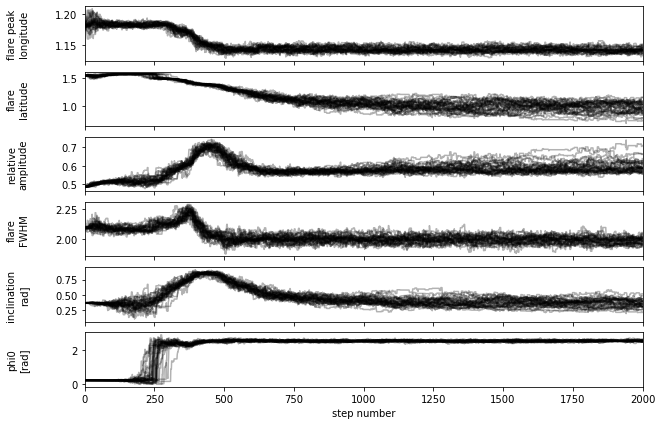

In [31]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['flare peak\nlongitude', 'flare\nlatitude', 'relative\namplitude', 'flare\nFWHM', 'inclination \nrad]', 'phi0\n[rad]']
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig(f"{target.prefix}{target.ID}_2000_fixed.png",dpi=300)

(32000, 6)


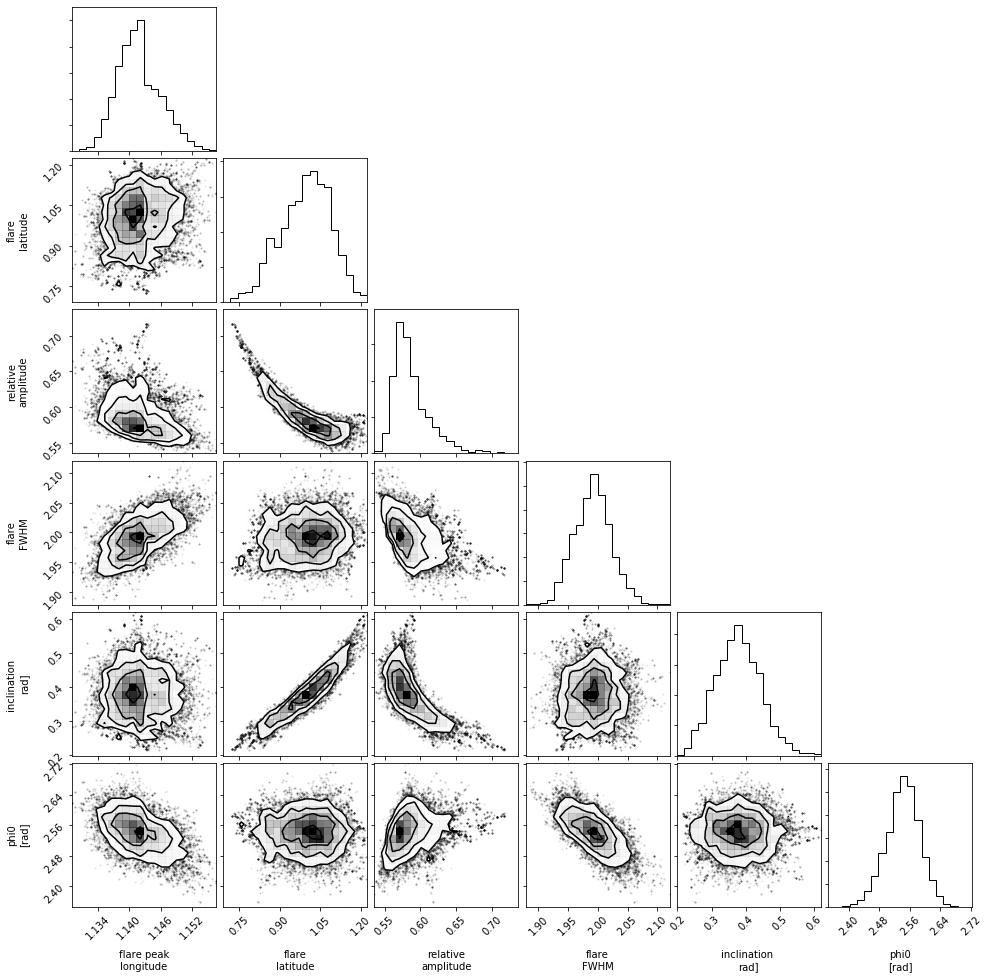

In [32]:

flat_samples = sampler.get_chain(discard=1000, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)# truths=[phi_a, theta_a, a, fwhm,i_mu, phi0]);
plt.savefig(f"{target.prefix}{target.ID}_2000_corner_disc1000_fixed.png",dpi=300)

In [40]:
.75/np.pi*180-1.1/np.pi*180 #pm 10
1/np.pi*180

57.29577951308232

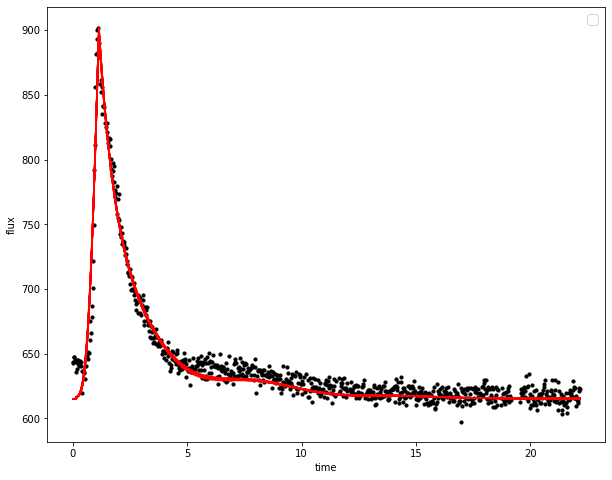

In [41]:
inds = np.random.randint(len(flat_samples), size=50)
plt.figure(figsize=(10,8))
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(phi, flux, s=10, c="k")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    phi_a, theta_a, a, fwhm, i, phi0 = sample
   # plt.plot(phi, aflare(phi, phi_a, fwhm, a*median)+ median, c="grey", alpha=0.05, linewidth=3)
    plt.plot(phi, big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=0.5,)
#plt.plot(phi, flare+median, c="r",linewidth=1)
plt.legend(fontsize=14)
plt.xlabel("time")
plt.ylabel("flux");
plt.savefig(f"{target.prefix}{target.ID}_2000_flarefit_disc1000_fixed.png",dpi=300)

In [0]:
samples = sampler.chain[:, 10:, :].reshape((-1, ndim))
#samples[:, 2] = np.exp(samples[:, 2])
t0_mcmc, dur_mcmc, ampl_mcmc, c, d, e = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
t0_mcmc, dur_mcmc, ampl_mcmc

In [0]:
e_t0 = (t0_mcmc[1] + t0_mcmc[2])/2.
e_dur = (dur_mcmc[1] + dur_mcmc[2])/2.
e_ampl = (ampl_mcmc[1] + ampl_mcmc[2])/2.

In [0]:

def ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [0]:

def t0_ED(x):
    return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
def dur_ED(x):
    return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
def ampl_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
def median_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

In [0]:
check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
assert E_median == pytest.approx(E_median,rel=1e-4)
e_median, median

In [0]:
EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
EDval,e_ED

In [0]:
with open(f"{CWD}/data/summary/results.csv", "a") as k:
    stri = (f"{target.prefix} {target.ID},{EDval:.0f},{e_ED:.0f},"\
            f"{t0_mcmc[0]:.5f},{e_t0:.5f},"\
            f"{dur_mcmc[0]*6:.5f},{e_dur*6:.5f},"\
            f"{ampl_mcmc[0]/median:.5f},{e_ampl/median:.5f}\n"\
            f"{period.value:.2f}")
   # stri = "ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot_h\n"
    k.write(stri)